# Data EDA

## 필요 라이브러리 임포트 및 데이터 로드

In [12]:
import torch
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from sklearn.preprocessing import MinMaxScaler
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import re

/data/ephemeral/home/moon/csat/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
# 난수 고정
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(42) # magic number :)

In [3]:
import pandas as pd
from ast import literal_eval

# 데이터 로드
dataset = pd.read_csv('../data/feature_engineering_train.csv') 
df = pd.DataFrame(dataset)

display(df.head(3))

,id,paragraph,question,choices,answer,question_plus,subject,from,distractor_attractiveness,distractor_attractiveness_simhash,...,lq_term_density,lq_modifier_ratio,lq_score,q_p_similarity,choice_p_similarity,extreme_correct_match,is_negative_llm,cognitive_type,reasoning_step,quadrant_label
0,generation-for-nlp-425,"상소하여 아뢰기를 , “신이 좌참 찬 송준길이 올린 차자를 보았는데 , 상복(喪服)...",상소한 인물이 속한 붕당에 대한 설명으로 옳은 것만을 모두 고르면?,"['ㄱ, ㄴ', 'ㄱ, ㄷ', 'ㄴ, ㄹ', 'ㄷ, ㄹ']",2,NaN,한국사,KMMLU,0.805455,0.703125,...,0.034884,0.069767,11.894186,0.467032,0.249686,NaN,0,분석,2,Q4 (우하단)
1,generation-for-nlp-426,"(가)은/는 의병계열과 애국계몽 운동 계열의 비밀결사가 모여 결성된 조직으로, 총사...",(가)에 대한 설명으로 옳지 않은 것은?,"['고려 문종 때에 남경(南京)으로 승격되었다.', '종루(鐘樓), 이현, 칠패 등...",1,NaN,한국사,KMMLU,0.478597,0.656250,...,0.125000,0.062500,15.480882,0.170359,0.261985,NaN,1,분석,2,Q1 (우상단)
2,generation-for-nlp-427,나는 삼한(三韓) 산천의 음덕을 입어 대업을 이루었다.(가)는/은 수덕(水德)이 순...,(가) 지역에 대한 설명으로 옳은 것은?,"['이곳에 대장도감을 설치하여 재조대장경을 만들었다.', '지눌이 이곳에서 수선사 ...",4,NaN,한국사,KMMLU,0.409381,0.656250,...,0.062500,0.031250,10.215086,0.262167,0.385297,NaN,0,지식/이해,1,Q4 (우하단)


In [4]:
df.columns

Index(['id', 'paragraph', 'question', 'choices', 'answer', 'question_plus',
       'subject', 'from', 'distractor_attractiveness',
       'distractor_attractiveness_simhash', 'final_distractor_attractiveness',
       'num_choices', 'avg_words_per_sent', 'num_paragraphs', 'lq_ttr',
       'lq_term_density', 'lq_modifier_ratio', 'lq_score', 'q_p_similarity',
       'choice_p_similarity', 'extreme_correct_match', 'is_negative_llm',
       'cognitive_type', 'reasoning_step', 'quadrant_label'],
      dtype='object')

In [16]:
# 1-1. 전체적인 데이터 구조 요약
print("### 데이터 기본 정보 ###")
df.info()

# 1-2. 결측치 비율 확인
print("\n### 결측치 비율 (%) ###")
print((df.isnull().sum()))

### 데이터 기본 정보 ###
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2031 entries, 0 to 2030
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   id                                 2031 non-null   object 
 1   paragraph                          2031 non-null   object 
 2   question                           2031 non-null   object 
 3   choices                            2031 non-null   object 
 4   answer                             2031 non-null   int64  
 5   question_plus                      0 non-null      float64
 6   subject                            2031 non-null   object 
 7   from                               2031 non-null   object 
 8   distractor_attractiveness          2031 non-null   float64
 9   distractor_attractiveness_simhash  2031 non-null   float64
 10  final_distractor_attractiveness    2031 non-null   float64
 11  num_choices                        203

## 데이터 중복 확인

In [17]:
unique_len = len(df['paragraph'].unique())
whole_len = len(df)
duplicate_len = whole_len - unique_len

print('=== 중복 데이터 확인 ===\n')
print(f'중복제거 지문 수: {unique_len}개')
print(f'전체 지문 수: {whole_len}개')

# paragraph 중복
para_dup = df['paragraph'].duplicated().sum()
print(f'paragraph 중복: {para_dup}개 (약 {(duplicate_len/whole_len*100):2f})')

# question 중복
q_dup = df['question'].duplicated().sum()
print(f'question 중복: {q_dup}개')

# answer 중복 (중복이 많은 것이 정상)
ans_dup = df['answer'].duplicated().sum()
print(f'answer 중복: {ans_dup}개')

# choices 중복 (리스트라서 문자열로 변환 후 확인)
choices_dup = df['choices'].astype(str).duplicated().sum()
print(f'choices 중복: {choices_dup}개')
# 전체 행 중복 (choices 컬럼을 제외하고 확인)
row_dup = df[['id', 'paragraph', 'question']].duplicated().sum()
print(f'\n전체 행 중복 (id, paragraph, question, answer 기준): {row_dup}개')

=== 중복 데이터 확인 ===

중복제거 지문 수: 1871개
전체 지문 수: 2031개
paragraph 중복: 160개 (약 7.877893)
question 중복: 46개
answer 중복: 2026개
choices 중복: 9개

전체 행 중복 (id, paragraph, question, answer 기준): 0개


In [18]:
# question이 중복인 데이터만 추출
duplicated_questions = df[df['question'].duplicated(keep=False)]

# 그 중에서 paragraph도 중복인지 확인
para_also_dup = duplicated_questions[duplicated_questions['paragraph'].duplicated()]
total_dup_questions = len(duplicated_questions)
para_also_dup_count = len(para_also_dup)

print(f'중복된 question 총 개수: {total_dup_questions}개')
print(f'그 중 paragraph도 중복인 경우: {para_also_dup_count}개')
print(f'paragraph가 다른 경우: {total_dup_questions - para_also_dup_count}개')
print('\n✅ 같은 지문에서 같은 질문이 중복되는 경우는 없음')

중복된 question 총 개수: 65개
그 중 paragraph도 중복인 경우: 5개
paragraph가 다른 경우: 60개

✅ 같은 지문에서 같은 질문이 중복되는 경우는 없음


## 메타데이터 분포 확인

/tmp/ipykernel_273522/4224053929.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='answer', data=df_dist, ax=axes[1, 0], palette='viridis')


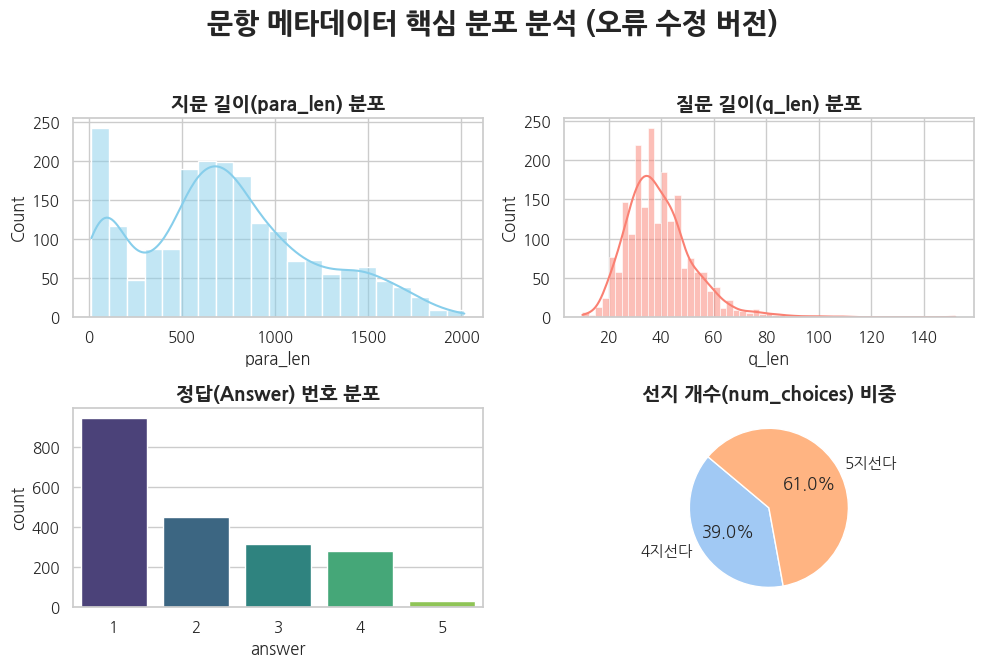

In [19]:
# 1. 시각화할 피처 추가 계산 (안전한 리스트 변환 로직 추가)
df_dist = df.copy()

def get_choices_length(x):
    if isinstance(x, list):
        return len(x)
    if isinstance(x, str):
        try:
            # 문자열 형태의 리스트 ["a", "b"]를 실제 리스트로 변환
            actual_list = ast.literal_eval(x)
            if isinstance(actual_list, list):
                return len(actual_list)
        except:
            return 0
    return 0

df_dist['para_len'] = df_dist['paragraph'].apply(lambda x: len(str(x)) if x and str(x) != 'nan' else 0)
df_dist['q_len'] = df_dist['question'].apply(lambda x: len(str(x)) if x and str(x) != 'nan' else 0)
# 수정된 함수 적용
df_dist['num_choices'] = df_dist['choices'].apply(get_choices_length)

# 2. 서브플롯 구성
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
fig.suptitle('문항 메타데이터 핵심 분포 분석 (오류 수정 버전)', fontsize=20, fontweight='bold', y=0.98)

# (1) 지문 길이 분포
sns.histplot(df_dist['para_len'], kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('지문 길이(para_len) 분포', fontsize=14, fontweight='bold')

# (2) 질문 길이 분포
sns.histplot(df_dist['q_len'], kde=True, ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('질문 길이(q_len) 분포', fontsize=14, fontweight='bold')

# (3) 정답(answer) 번호 분포
sns.countplot(x='answer', data=df_dist, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('정답(Answer) 번호 분포', fontsize=14, fontweight='bold')

# (4) 선지 개수 비중 (0개 제외 필터링 후 시각화)
choice_counts = df_dist[df_dist['num_choices'] > 0]['num_choices'].value_counts().sort_index()
if not choice_counts.empty:
    axes[1, 1].pie(choice_counts, 
                    labels=[f'{int(i)}지선다' for i in choice_counts.index], 
                    autopct='%1.1f%%', 
                    startangle=140, 
                    colors=sns.color_palette('pastel'))
    axes[1, 1].set_title('선지 개수(num_choices) 비중', fontsize=14, fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, '선지 데이터를 확인할 수 없습니다.', ha='center')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 생성된 피처 분포 확인

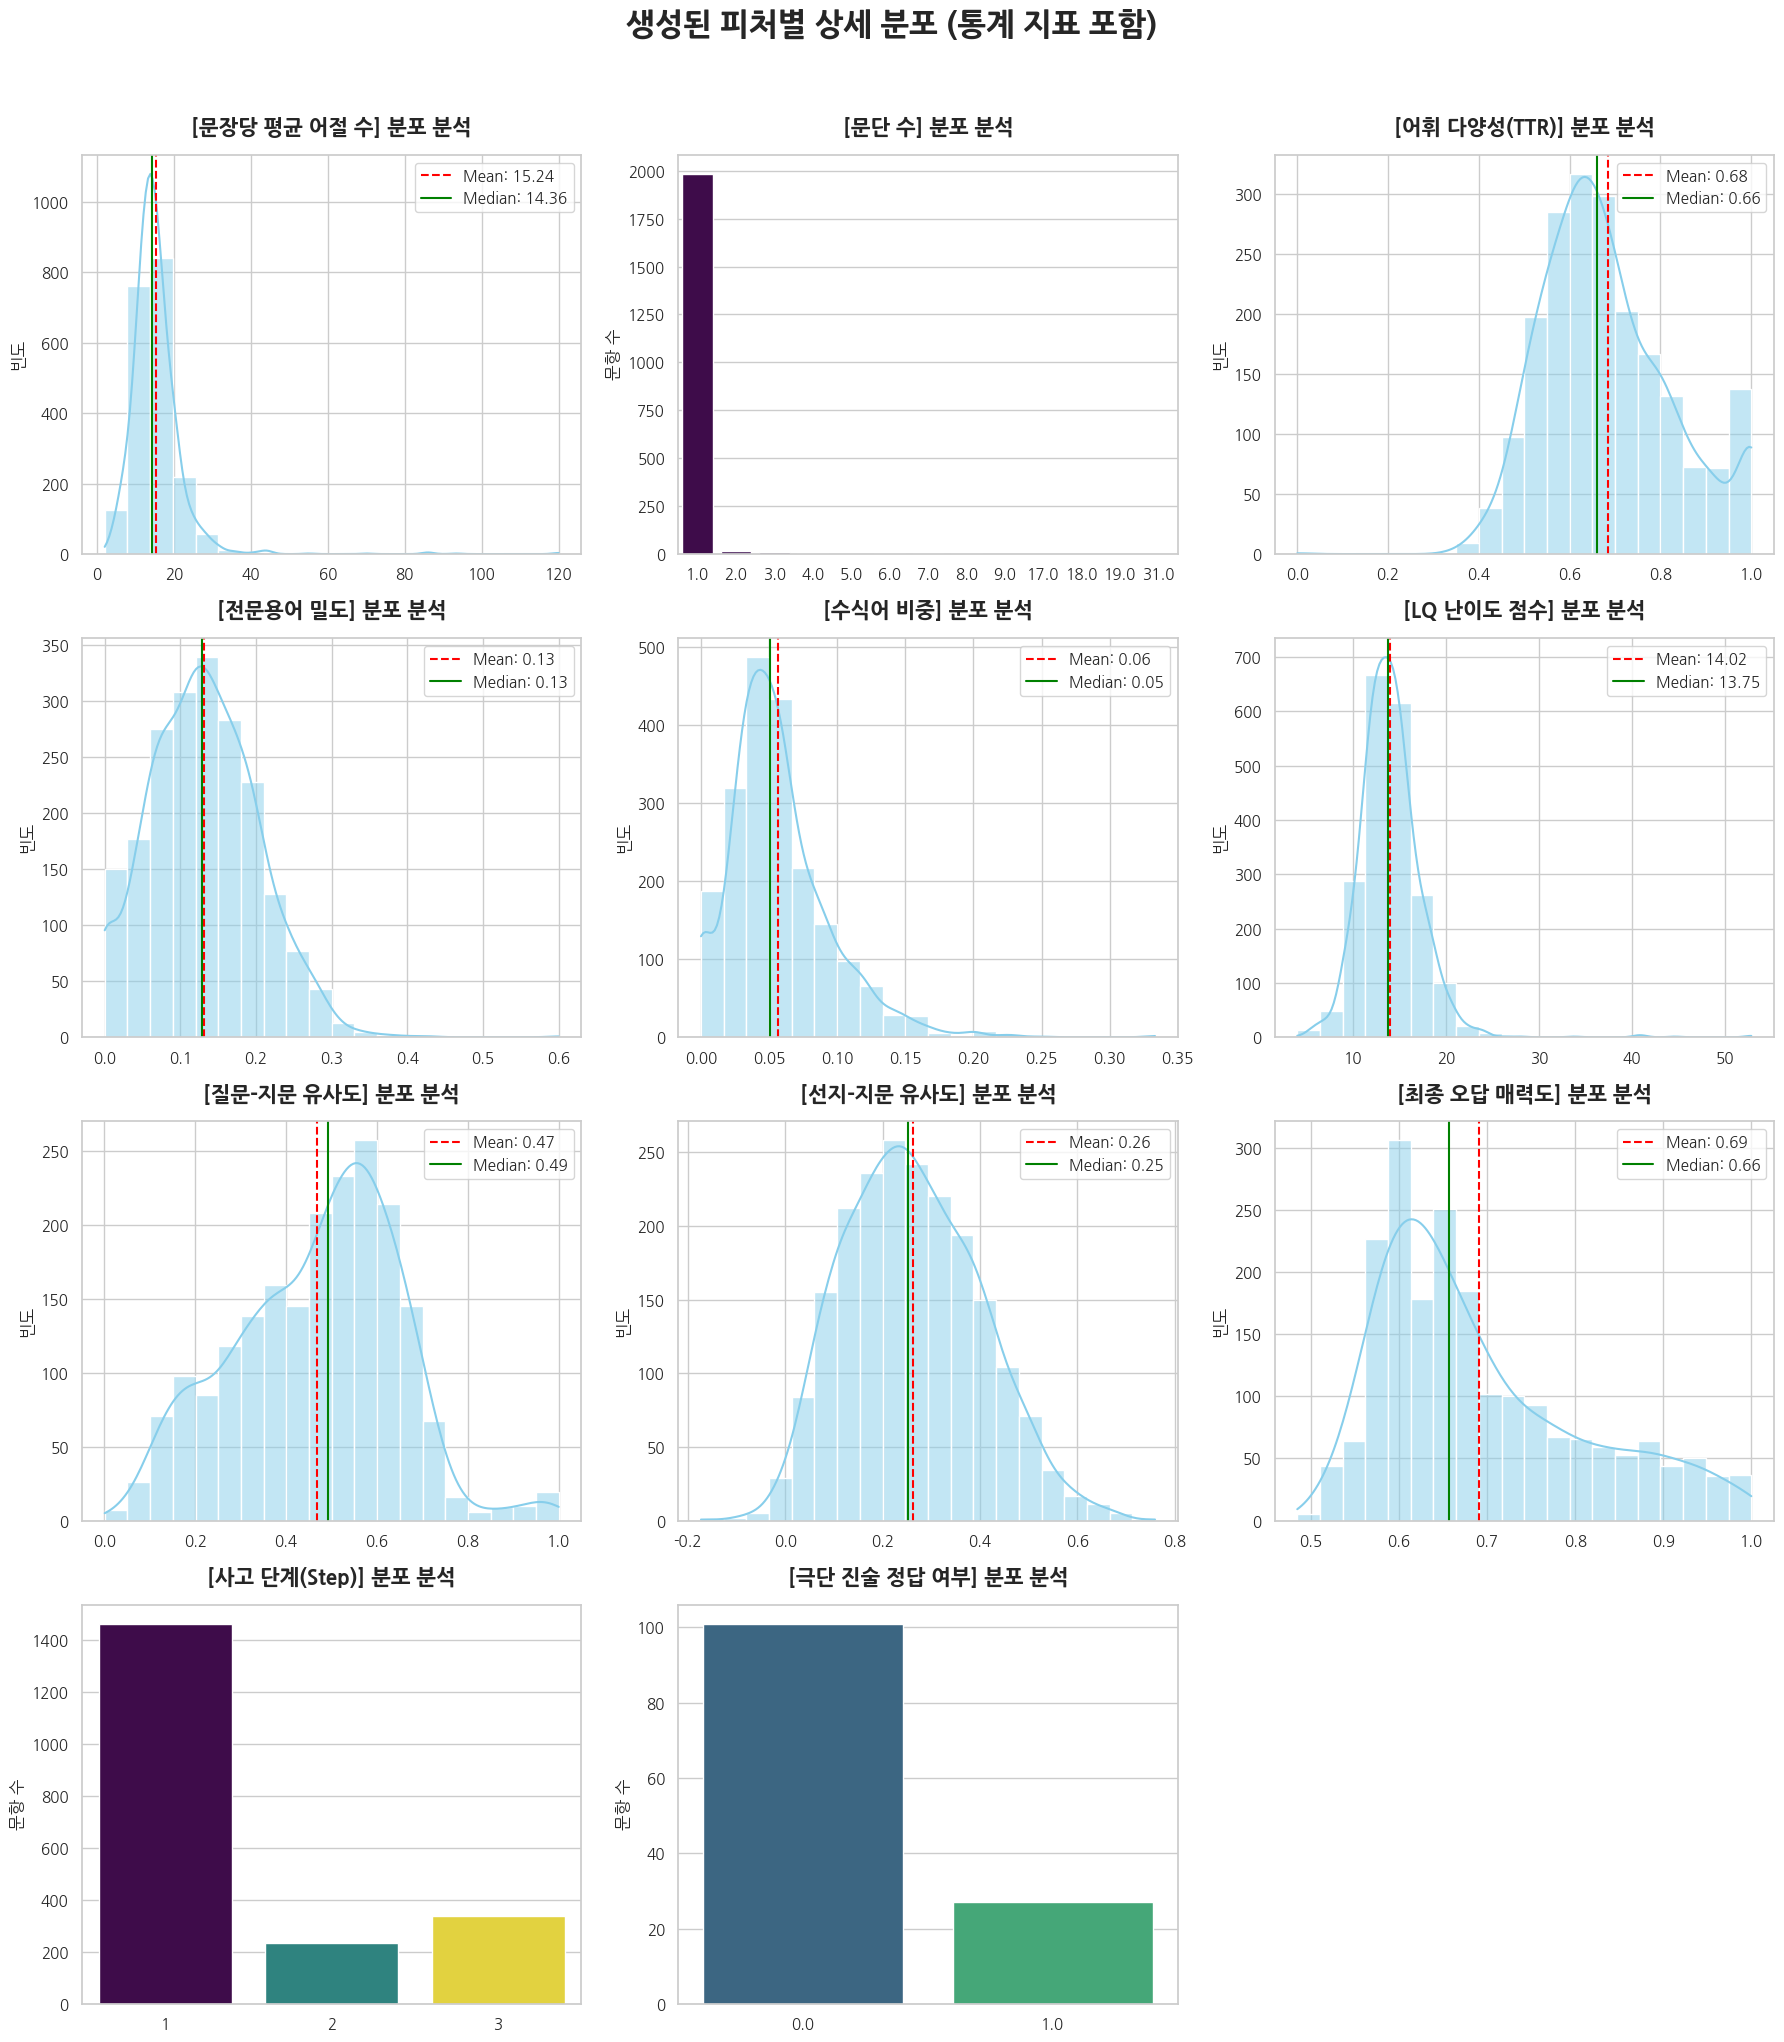

In [20]:
# 1. 한글 폰트 및 스타일 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", font='NanumGothic')

# 2. 한글 라벨 설정 (사용자님 제공 리스트 반영)
korean_labels = {
    'avg_words_per_sent': '문장당 평균 어절 수',
    'num_paragraphs': '문단 수',
    'lq_ttr': '어휘 다양성(TTR)',
    'lq_term_density': '전문용어 밀도',
    'lq_modifier_ratio': '수식어 비중',
    'lq_score': 'LQ 난이도 점수',
    'q_p_similarity': '질문-지문 유사도',
    'choice_p_similarity': '선지-지문 유사도',
    'final_distractor_attractiveness': '최종 오답 매력도',
    'reasoning_step': '사고 단계(Step)',
    'extreme_correct_match': '극단 진술 정답 여부'
}

# 3. 데이터프레임에 존재하는 피처만 선별
features = [col for col in korean_labels.keys() if col in df.columns]

# 4. 레이아웃 설정 (가로 3열)
cols = 3
rows = (len(features) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten()

# 5. 시각화 루프
for i, col in enumerate(features):
    # 범주형 변수 처리 (문단 수, 사고 단계 등)
    if col in ['num_paragraphs', 'reasoning_step', 'extreme_correct_match']:
        sns.countplot(x=df[col].dropna(), ax=axes[i], palette='viridis', hue=df[col].dropna(), legend=False)
        axes[i].set_ylabel('문항 수')
        
    # 연속형 변수 처리 (점수, 유사도 등)
    else:
        clean_data = df[col].dropna()
        sns.histplot(clean_data, ax=axes[i], kde=True, color='skyblue', bins=20, edgecolor='white')
        axes[i].set_ylabel('빈도')
        
        # 평균값(Mean)과 중앙값(Median) 표시
        mean_val = clean_data.mean()
        median_val = clean_data.median()
        axes[i].axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
        axes[i].axvline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
        axes[i].legend()

    axes[i].set_title(f"[{korean_labels[col]}] 분포 분석", fontsize=15, fontweight='bold', pad=15)
    axes[i].set_xlabel('')

# 남은 빈 서브플롯 숨기기
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('생성된 피처별 상세 분포 (통계 지표 포함)', fontsize=22, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

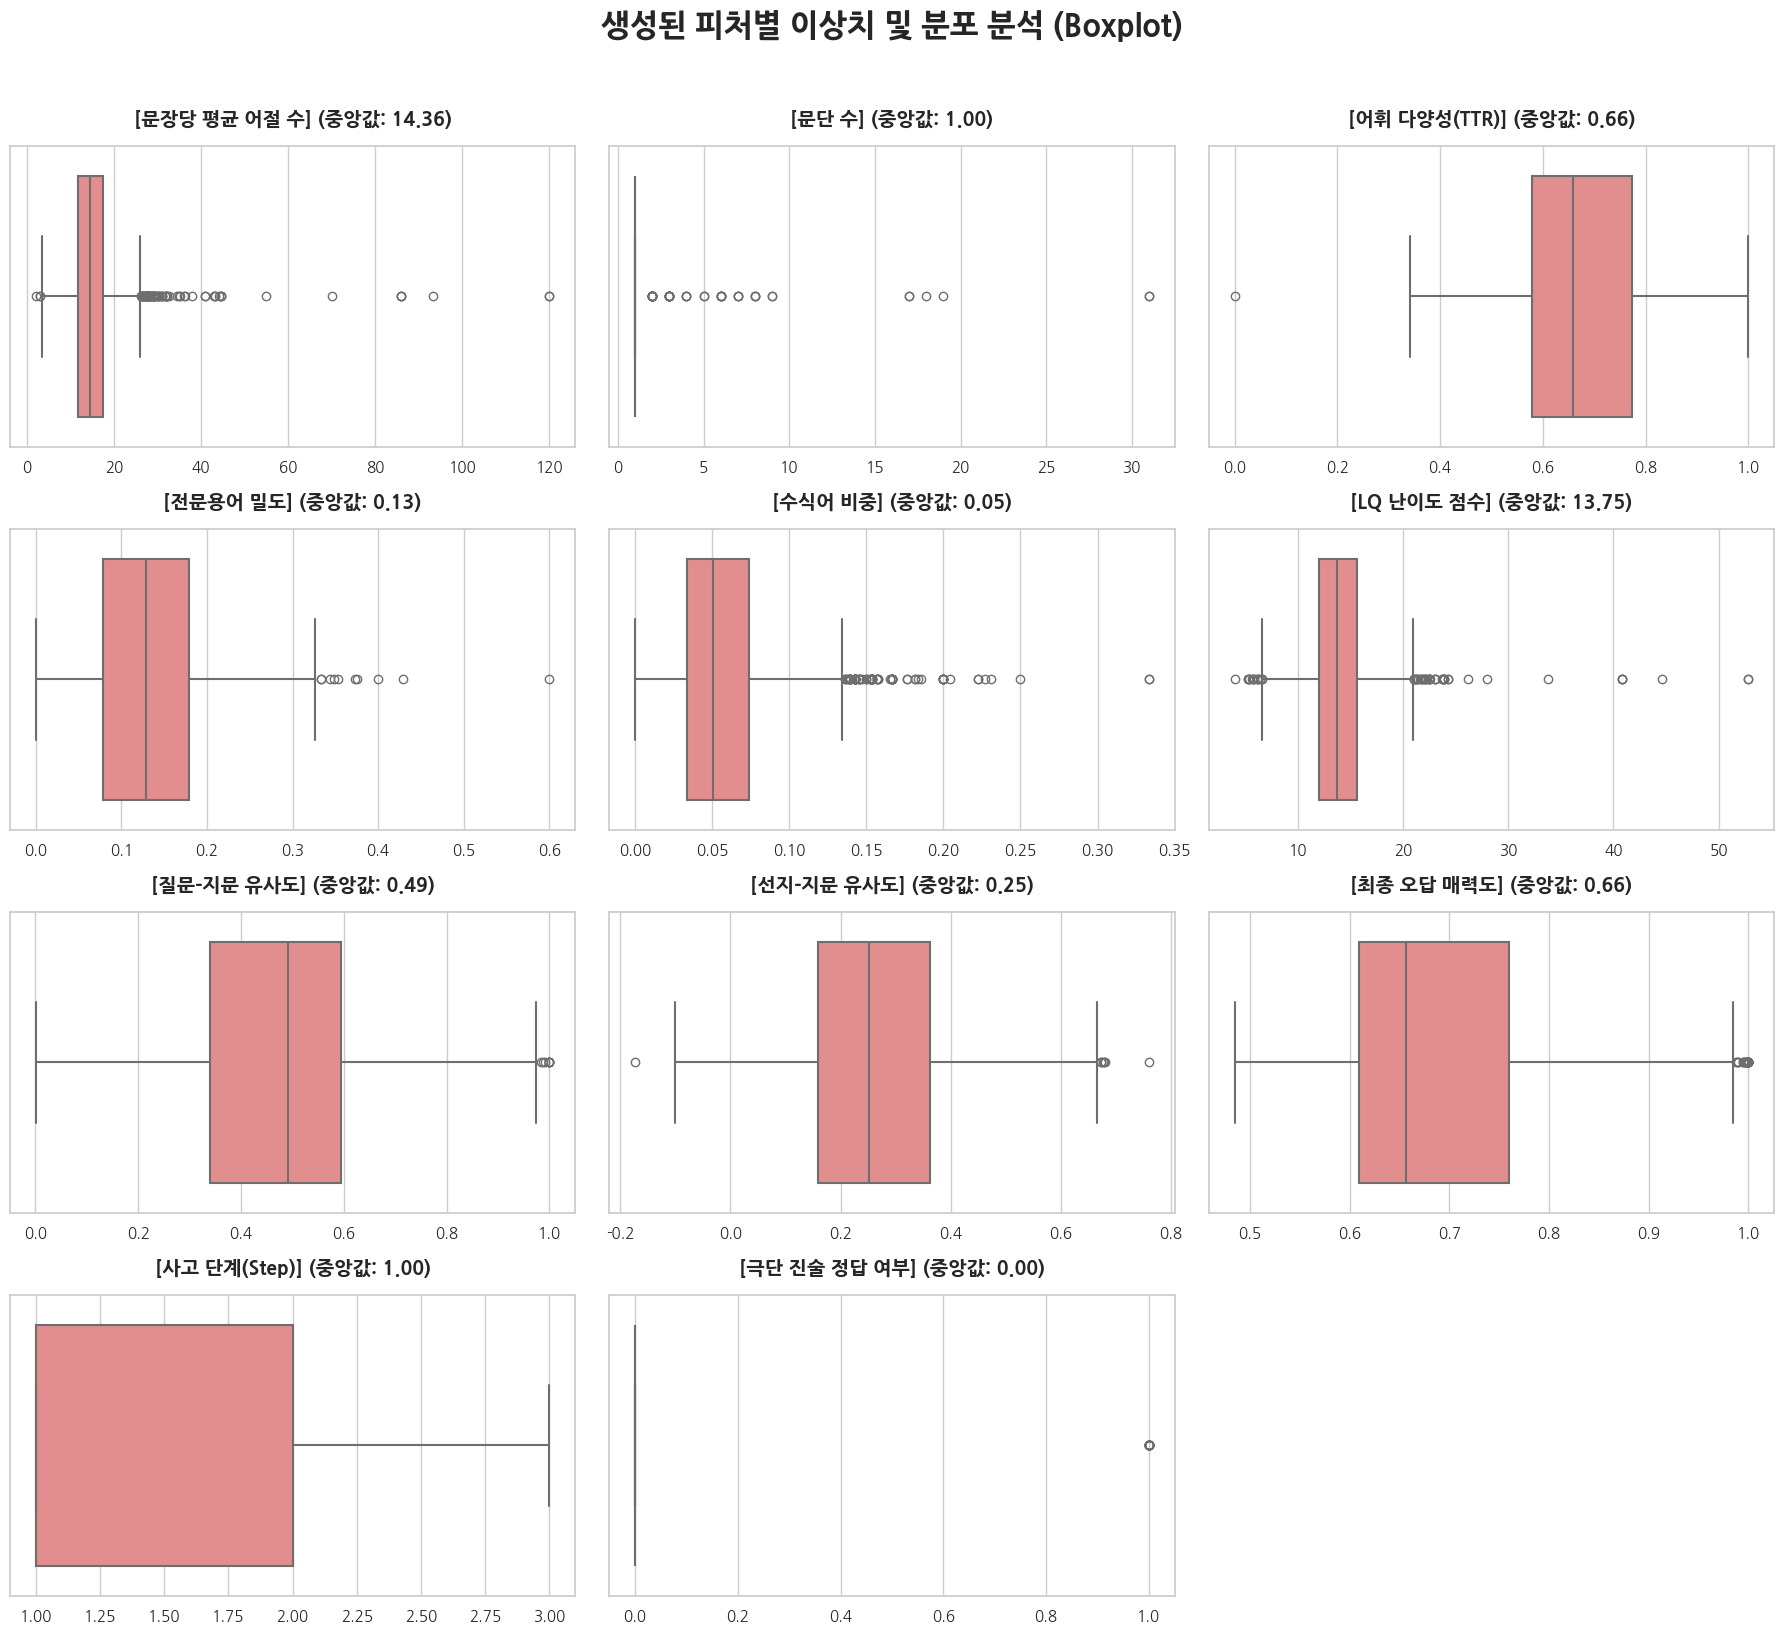

In [21]:
# 1. 한글 폰트 및 스타일 설정
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False
sns.set_theme(style="whitegrid", font='NanumGothic')

# 2. 한글 라벨 설정 (인지 피처 포함 고도화)
korean_labels = {
    'avg_words_per_sent': '문장당 평균 어절 수',
    'num_paragraphs': '문단 수',
    'lq_ttr': '어휘 다양성(TTR)',
    'lq_term_density': '전문용어 밀도',
    'lq_modifier_ratio': '수식어 비중',
    'lq_score': 'LQ 난이도 점수',
    'q_p_similarity': '질문-지문 유사도',
    'choice_p_similarity': '선지-지문 유사도',
    'final_distractor_attractiveness': '최종 오답 매력도',
    'reasoning_step': '사고 단계(Step)',
    'extreme_correct_match': '극단 진술 정답 여부'
}

# 3. 데이터프레임에 존재하는 피처만 선별
features = [col for col in korean_labels.keys() if col in df.columns]

# 4. 레이아웃 설정 (가로 3열)
cols = 3
rows = (len(features) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
axes = axes.flatten()

# 5. 시각화 루프
for i, col in enumerate(features):
    # 결측치 제거 후 깨끗한 데이터 준비
    clean_data = df[col].dropna()
    
    if not clean_data.empty:
        # Boxplot 그리기 (이상치 크기 조절: fliersize)
        sns.boxplot(x=clean_data, ax=axes[i], color='lightcoral', fliersize=6, linewidth=1.5)
        
        # 중앙값(Median) 수치 표기
        median_val = clean_data.median()
        axes[i].set_title(f"[{korean_labels[col]}] (중앙값: {median_val:.2f})", 
                          fontsize=14, fontweight='bold', pad=15)
    else:
        axes[i].text(0.5, 0.5, '데이터 없음', ha='center', va='center')
        axes[i].set_title(f"[{korean_labels[col]}]", fontsize=14, fontweight='bold', pad=15)
        
    axes[i].set_xlabel('')

# 남은 빈 서브플롯 숨기기
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle('생성된 피처별 이상치 및 분포 분석 (Boxplot)', fontsize=22, fontweight='bold', y=1.02)
plt.tight_layout()

## Boxplot 이상치 저장

In [22]:
# def export_outliers_to_csv(df, target_cols, output_path="../data/outlier_analysis_report.csv"):
#     """
#     지정한 컬럼들에서 IQR(1.5배) 기준으로 이상치를 찾아 CSV로 저장합니다.
#     """
#     outlier_df = df.copy()
#     all_outlier_indices = set()
    
#     # 각 이상치가 어떤 피처에서 발생했는지 기록하기 위한 사전
#     outlier_reason_dict = {}

#     for col in target_cols:
#         if col not in df.columns:
#             continue
            
#         data = df[col].dropna()
#         if len(data) < 4:  # 데이터가 너무 적으면 사분위수 계산 의미 없음
#             continue
            
#         # 1. IQR 계산
#         Q1 = data.quantile(0.25)
#         Q3 = data.quantile(0.75)
#         IQR = Q3 - Q1
        
#         # 2. 경계값 설정 (1.5배 규정)
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
        
#         # 3. 해당 컬럼의 이상치 필터링
#         is_outlier = (df[col] < lower_bound) | (df[col] > upper_bound)
#         idx_list = df[is_outlier].index.tolist()
        
#         # 이상치 발생 정보 기록
#         for idx in idx_list:
#             reason = f"{col}({df.loc[idx, col]:.2f})"
#             if idx in outlier_reason_dict:
#                 outlier_reason_dict[idx] += f", {reason}"
#             else:
#                 outlier_reason_dict[idx] = reason
        
#         all_outlier_indices.update(idx_list)

#     # 4. 이상치 데이터만 추출 및 원인 컬럼 추가
#     final_outliers = df.loc[list(all_outlier_indices)].copy()
#     final_outliers['outlier_reason'] = final_outliers.index.map(outlier_reason_dict)

#     # 5. CSV 저장 (한글 깨짐 방지 encoding 적용)
#     if not final_outliers.empty:
#         final_outliers.to_csv(output_path, index=False, encoding='utf-8-sig')
#         print(f"✅ 총 {len(final_outliers)}개의 이상치 문항을 발견하여 '{output_path}'에 저장했습니다.")
        
#         # 요약 통계 출력
#         print("\n[이상치 요약]")
#         print(final_outliers['outlier_reason'].value_counts().head(10))
#     else:
#         print("🔍 분석 결과, 이상치로 분류될 만한 문항이 없습니다.")

# # --- 실행부 ---
# # 분석할 피처 리스트 (위에서 boxplot으로 그린 피처들)
# analysis_features = [
#     'avg_words_per_sent', 'lq_ttr', 'lq_term_density', 
#     'lq_modifier_ratio', 'lq_score', 'q_p_similarity', 
#     'choice_p_similarity', 'final_distractor_attractiveness'
# ]

# export_outliers_to_csv(df, analysis_features)

## subject 별 10개씩 저장

In [23]:
# # 1. 과목(subject)별로 10개씩 샘플링하는 함수 정의
# def get_subject_samples(df, n_samples=10):
#     # 각 과목 그룹별로 n개씩 추출 (데이터가 부족하면 전체 추출)
#     sampled_df = df.groupby('subject', group_keys=False).apply(
#         lambda x: x.sample(min(len(x), n_samples), random_state=42)
#     )
#     return sampled_df

# # 2. 샘플링 실행
# df_subject_samples = get_subject_samples(df, n_samples=10)

# # 3. CSV 파일로 저장 (한글 깨짐 방지 encoding 적용)
# output_file = "../data/samples_by_subject_10.csv"
# df_subject_samples.to_csv(output_file, index=False, encoding='utf-8-sig')

# # 4. 결과 출력 및 확인
# print(f"과목별 최대 10개씩 샘플링하여 총 {len(df_subject_samples)}개의 문항을 저장했습니다.")
# print(f"파일명: {output_file}")

# print("\n[과목별 추출 결과]")
# print(df_subject_samples['subject'].value_counts())

## 출처 별 분석

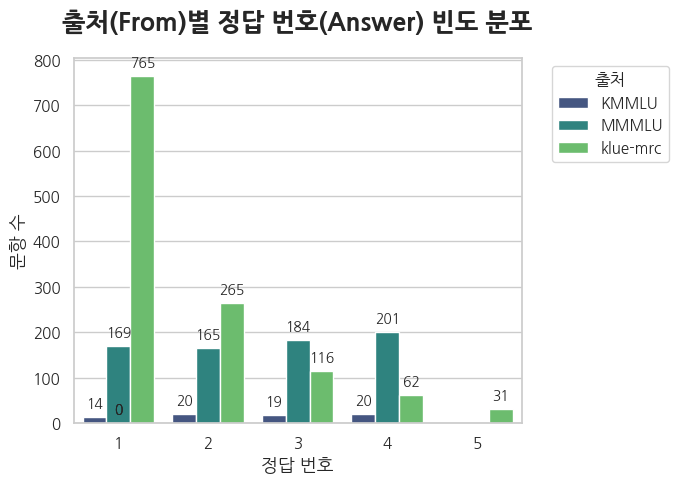

<<<출처별 정답 번호 상세 빈도표>>>


answer,1,2,3,4,5
from,,,,,
KMMLU,14,20,19,20,0
MMMLU,169,165,184,201,0
klue-mrc,765,265,116,62,31


In [24]:
# 1. 시각화 스타일 및 폰트 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic' # 윈도우 한글 설정
plt.rcParams['axes.unicode_minus'] = False

# 2. 그래프 생성
plt.figure(figsize=(7, 5))

# hue='from'을 사용하여 정답 번호(1~5)별로 출처가 나란히 보이게 설정
ax = sns.countplot(x='answer', hue='from', data=df, palette='viridis')

# 3. 타이틀 및 라벨 설정
plt.title('출처(From)별 정답 번호(Answer) 빈도 분포', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('정답 번호', fontsize=13)
plt.ylabel('문항 수', fontsize=13)
plt.legend(title='출처', bbox_to_anchor=(1.05, 1), loc='upper left') # 범례를 그래프 밖으로 이동

# 4. 막대 위에 숫자 표시 (선택 사항)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# 5. 수치 데이터로 확인 (Cross-tabulation)
print("<<<출처별 정답 번호 상세 빈도표>>>")
cross_tab = pd.crosstab(df['from'], df['answer'])
display(cross_tab)

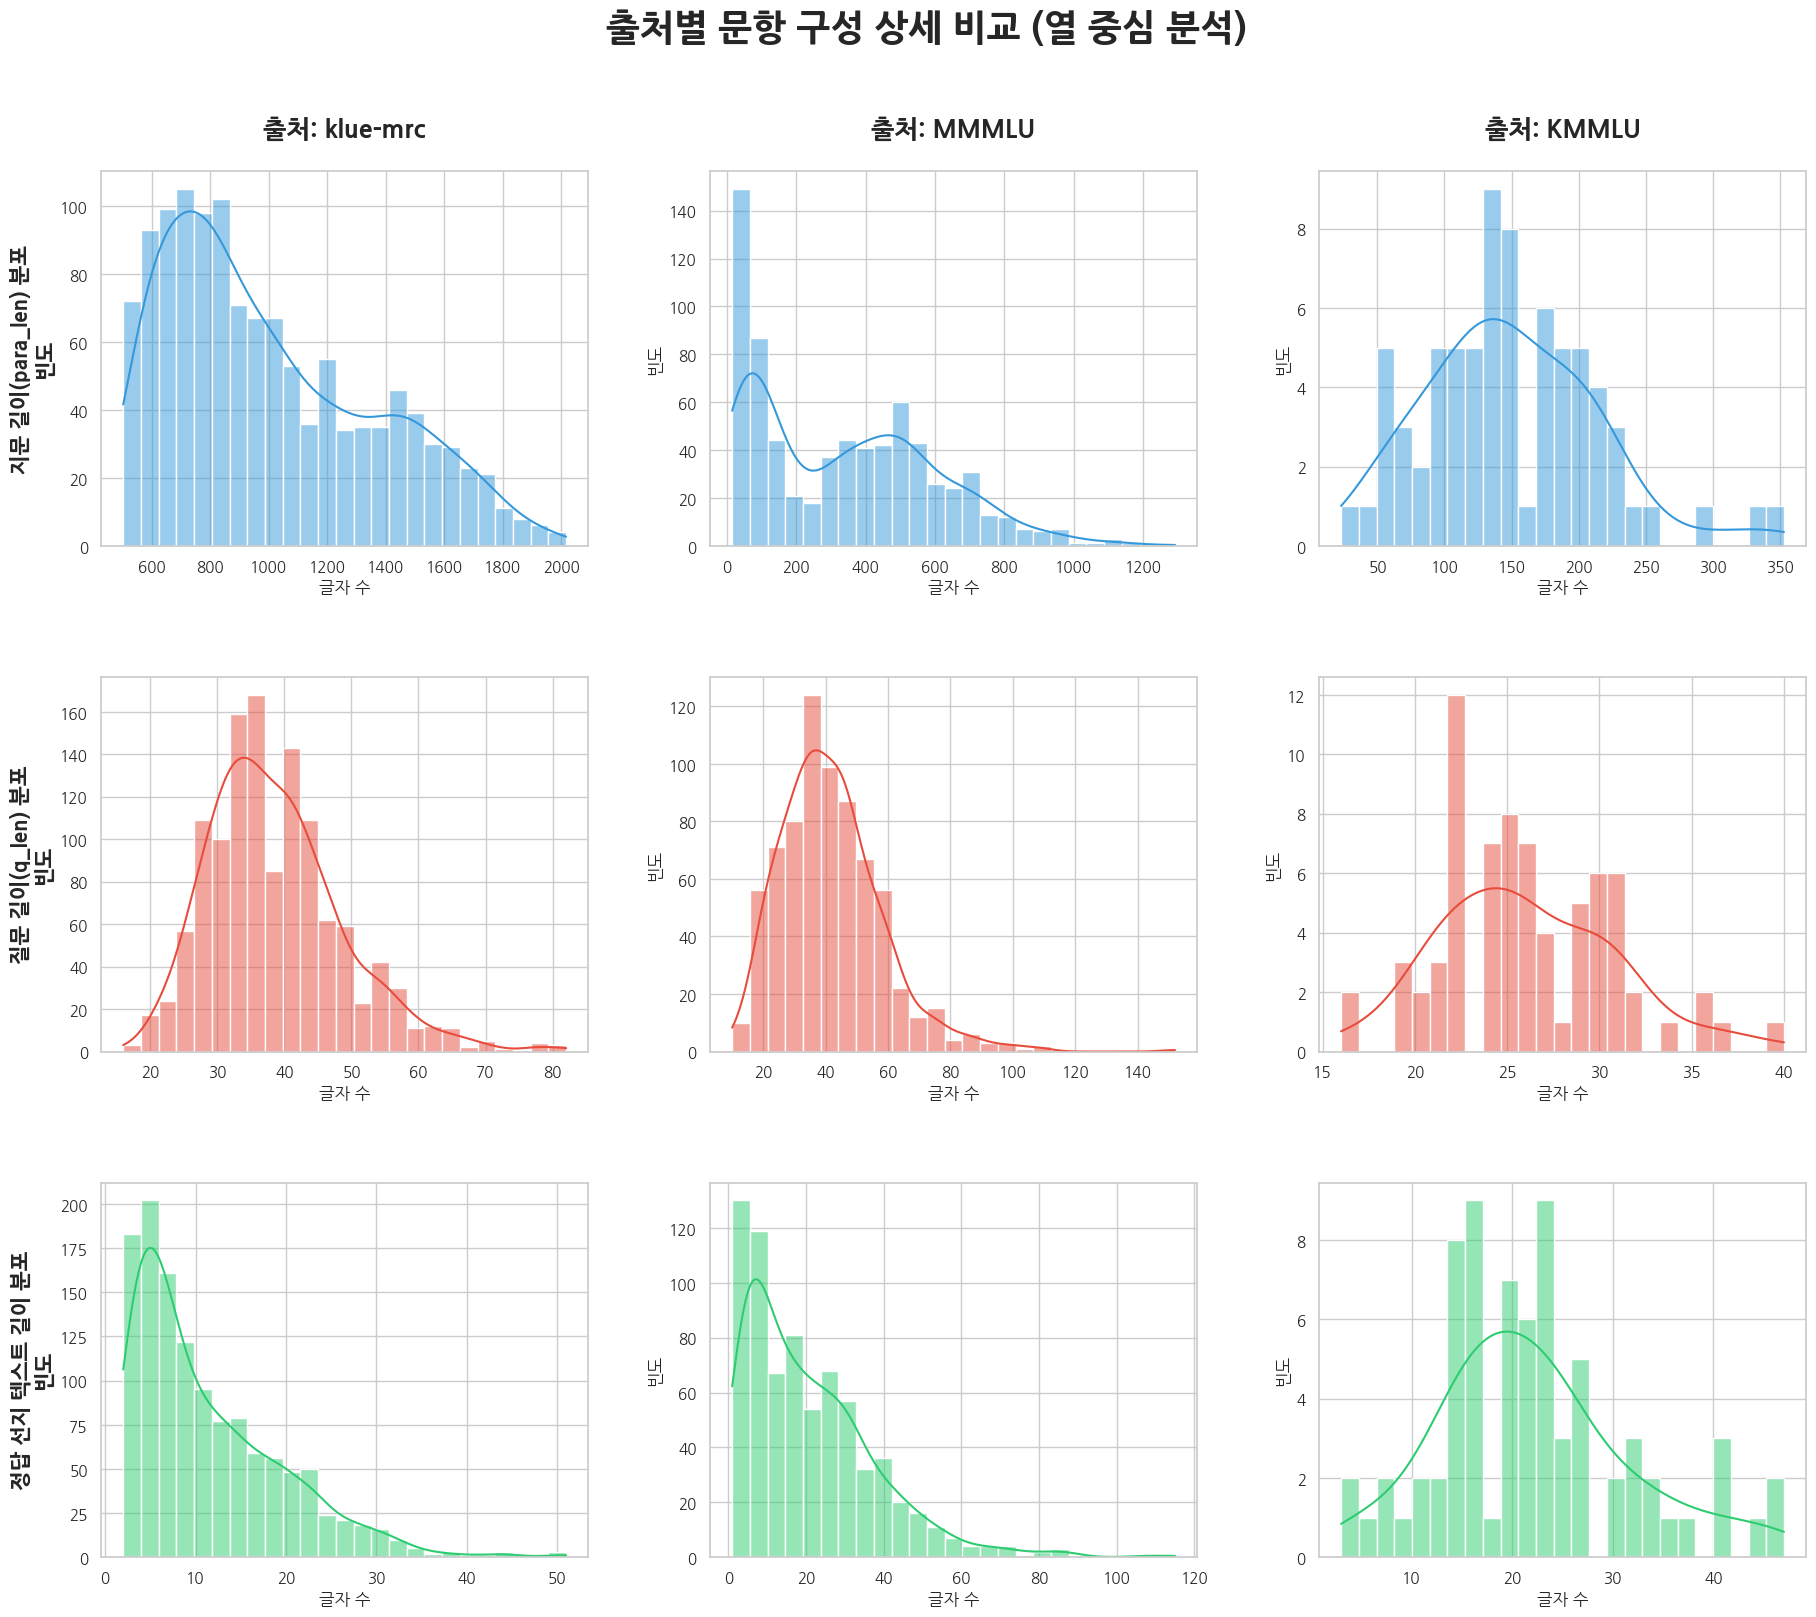

In [25]:
# 1. 시각화 스타일 및 한글 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

def plot_origin_3x3_inverted(df):
    df_plot = df.copy()
    
    # [데이터 전처리] 정답 선지의 실제 텍스트 길이 계산 함수
    def get_answer_text_len(row):
        try:
            choices = row['choices']
            if isinstance(choices, str):
                choices = ast.literal_eval(choices)
            ans_idx = int(float(row['answer'])) - 1
            if 0 <= ans_idx < len(choices):
                return len(str(choices[ans_idx]))
            return 0
        except:
            return 0

    df_plot['para_len'] = df_plot['paragraph'].str.len().fillna(0)
    df_plot['q_len'] = df_plot['question'].str.len().fillna(0)
    df_plot['ans_text_len'] = df_plot.apply(get_answer_text_len, axis=1)

    # 데이터가 많은 상위 3개 출처 선정
    top_origins = df_plot['from'].value_counts().nlargest(3).index.tolist()
    
    # 3행(지표) x 3열(출처) 레이아웃 생성
    fig, axes = plt.subplots(3, 3, figsize=(22, 18))
    plt.subplots_adjust(hspace=0.35, wspace=0.25)

    row_titles = ['지문 길이(para_len) 분포', '질문 길이(q_len) 분포', '정답 선지 텍스트 길이 분포']
    target_cols = ['para_len', 'q_len', 'ans_text_len']
    colors = ['#3498DB', '#E74C3C', '#2ECC71'] # 지표별 일관된 색상 적용

    # 루프 설계: 외곽 루프를 지표(Row)로, 내부 루프를 출처(Col)로 설정
    for row_idx, col_name in enumerate(target_cols):
        for col_idx, origin in enumerate(top_origins):
            ax = axes[row_idx, col_idx]
            
            # 해당 출처 데이터 필터링
            origin_data = df_plot[df_plot['from'] == origin]
            
            # 히스토그램 시각화
            sns.histplot(origin_data[col_name], kde=True, ax=ax, color=colors[row_idx], bins=25)
            
            # 열 제목 (첫 번째 행에만 출처명 표시)
            if row_idx == 0:
                ax.set_title(f"출처: {origin}", fontsize=18, fontweight='bold', pad=25)
            
            # 행 제목 (첫 번째 열에만 지표명 표시)
            if col_idx == 0:
                ax.set_ylabel(f"{row_titles[row_idx]}\n빈도", fontsize=15, fontweight='bold')
            else:
                ax.set_ylabel("빈도")
                
            ax.set_xlabel("글자 수")

    plt.suptitle('출처별 문항 구성 상세 비교 (열 중심 분석)', fontsize=26, fontweight='bold', y=0.97)
    plt.show()

# --- 실행 ---
plot_origin_3x3_inverted(df)

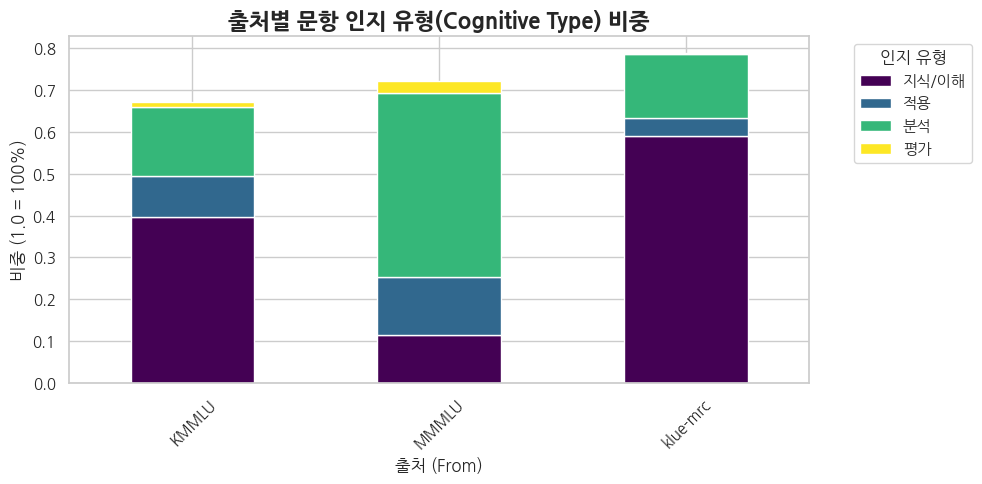

In [26]:
# 출처별 인지 유형(Cognitive Type) 비중 분석
plt.figure(figsize=(10, 5))
ct_pivot = pd.crosstab(df['from'], df['cognitive_type'], normalize='index')
# 인지적 깊이 순서대로 정렬 (지식 -> 적용 -> 분석 -> 평가)
order = [c for c in ['지식/이해', '적용', '분석', '평가'] if c in ct_pivot.columns]
ct_pivot[order].plot(kind='bar', stacked=True, colormap='viridis', ax=plt.gca())

plt.title('출처별 문항 인지 유형(Cognitive Type) 비중', fontsize=16, fontweight='bold')
plt.xlabel('출처 (From)')
plt.ylabel('비중 (1.0 = 100%)')
plt.legend(title='인지 유형', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

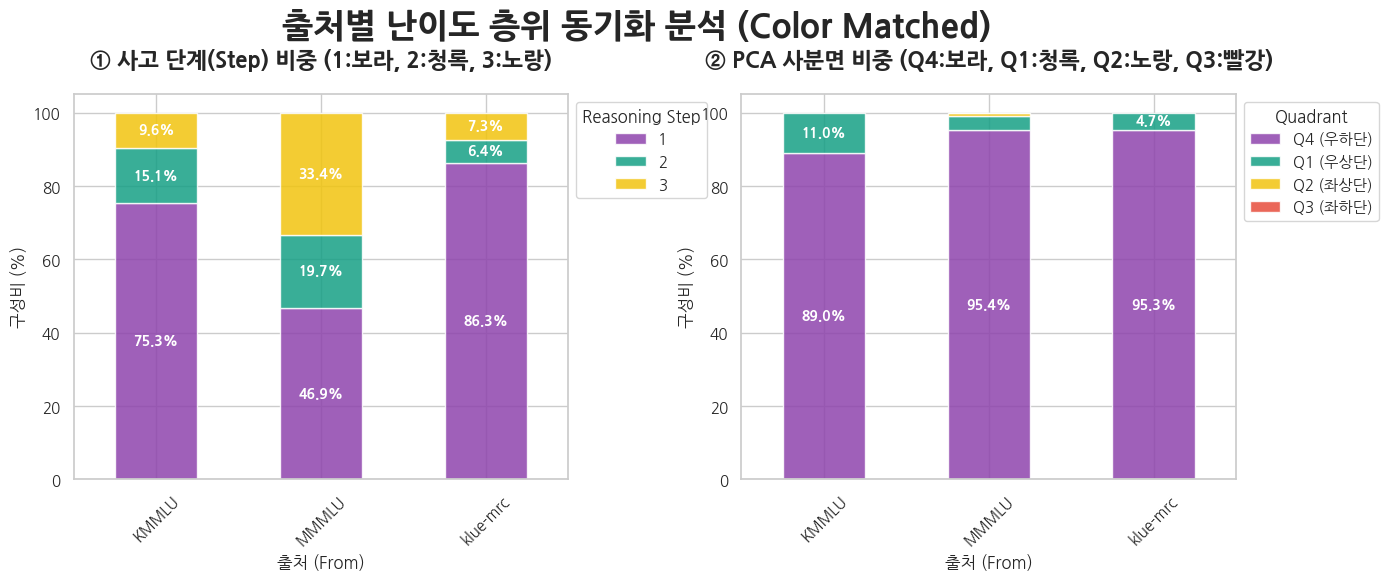

In [27]:
# 1. 시각화 스타일 및 한글 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

def plot_synchronized_color_dashboard(df):
    # 상위 주요 출처 선별
    top_origins = df['from'].value_counts().nlargest(5).index.tolist()
    df_filtered = df[df['from'].isin(top_origins)].copy()

    # --- [색상 팔레트 정의] ---
    # 사고 단계 색상 (1: 보라, 2: 청록, 3: 노랑)
    step_colors = {1.0: '#8E44AD', 2.0: '#16A085', 3.0: '#F1C40F'}
    
    # 사분면 색상 (Q4: 보라, Q1: 청록, Q2: 노랑, Q3: 빨강)
    quad_colors = {
        'Q4 (우하단)': '#8E44AD', # Step 1과 매칭
        'Q1 (우상단)': '#16A085', # Step 2와 매칭
        'Q2 (좌상단)': '#F1C40F', # Step 3과 매칭
        'Q3 (좌하단)': '#E74C3C'  # 독자적 킬러 색상
    }

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.35)

    # --- [좌측 차트] 사고 단계 비중 ---
    step_pct = pd.crosstab(df_filtered['from'], df_filtered['reasoning_step'], normalize='index') * 100
    # 컬럼(Step) 순서 보장
    available_steps = sorted(step_pct.columns)
    step_pct[available_steps].plot(kind='bar', stacked=True, ax=axes[0], 
                                    color=[step_colors[s] for s in available_steps], alpha=0.85)
    
    axes[0].set_title('① 사고 단계(Step) 비중 (1:보라, 2:청록, 3:노랑)', fontsize=16, fontweight='bold', pad=20)
    axes[0].set_ylabel('구성비 (%)')
    axes[0].legend(title='Reasoning Step', bbox_to_anchor=(1.0, 1.0))

    # --- [우측 차트] PCA 사분면 비중 ---
    quad_order = ['Q4 (우하단)', 'Q1 (우상단)', 'Q2 (좌상단)', 'Q3 (좌하단)']
    existing_quads = [q for q in quad_order if q in df_filtered['quadrant_label'].unique()]
    
    quad_pct = pd.crosstab(df_filtered['from'], df_filtered['quadrant_label'], normalize='index') * 100
    quad_pct = quad_pct[existing_quads] # 사용자 정의 순서로 정렬
    
    quad_pct.plot(kind='bar', stacked=True, ax=axes[1], 
                  color=[quad_colors[q] for q in existing_quads], alpha=0.85)
    
    axes[1].set_title('② PCA 사분면 비중 (Q4:보라, Q1:청록, Q2:노랑, Q3:빨강)', fontsize=16, fontweight='bold', pad=20)
    axes[1].set_ylabel('구성비 (%)')
    axes[1].legend(title='Quadrant', bbox_to_anchor=(1.0, 1.0))

    # 공통 설정 (퍼센트 텍스트 추가)
    for ax in axes:
        ax.set_xlabel('출처 (From)')
        ax.tick_params(axis='x', rotation=45)
        for p in ax.patches:
            h = p.get_height()
            if h > 4: # 4% 이상일 때만 표시
                ax.annotate(f'{h:.1f}%', (p.get_x() + p.get_width()/2., p.get_y() + h/2.),
                             ha='center', va='center', color='white', fontweight='bold', fontsize=10)

    plt.suptitle('출처별 난이도 층위 동기화 분석 (Color Matched)', fontsize=24, fontweight='bold', y=1.05)
    plt.show()

# --- 실행 ---
plot_synchronized_color_dashboard(df)

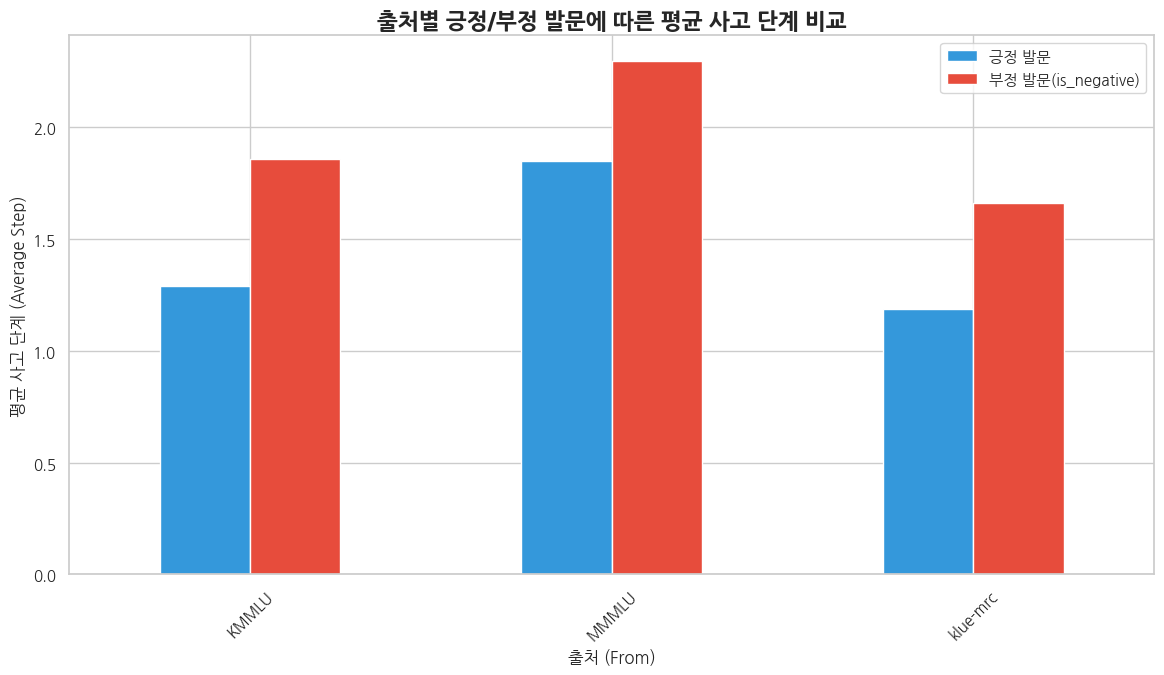

In [28]:
# 출처별 부정형 문항 비중 및 사고 단계 교차 분석
neg_step = df.groupby(['from', 'is_negative_llm'])['reasoning_step'].mean().unstack()

neg_step.plot(kind='bar', figsize=(14, 7), color=['#3498DB', '#E74C3C'])
plt.title('출처별 긍정/부정 발문에 따른 평균 사고 단계 비교', fontsize=16, fontweight='bold')
plt.xlabel('출처 (From)')
plt.ylabel('평균 사고 단계 (Average Step)')
plt.legend(['긍정 발문', '부정 발문(is_negative)'])
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_273522/2083845292.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='from', y=col, ax=axes[i],
/tmp/ipykernel_273522/2083845292.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='from', y=col, ax=axes[i],
/tmp/ipykernel_273522/2083845292.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='from', y=col, ax=axes[i],


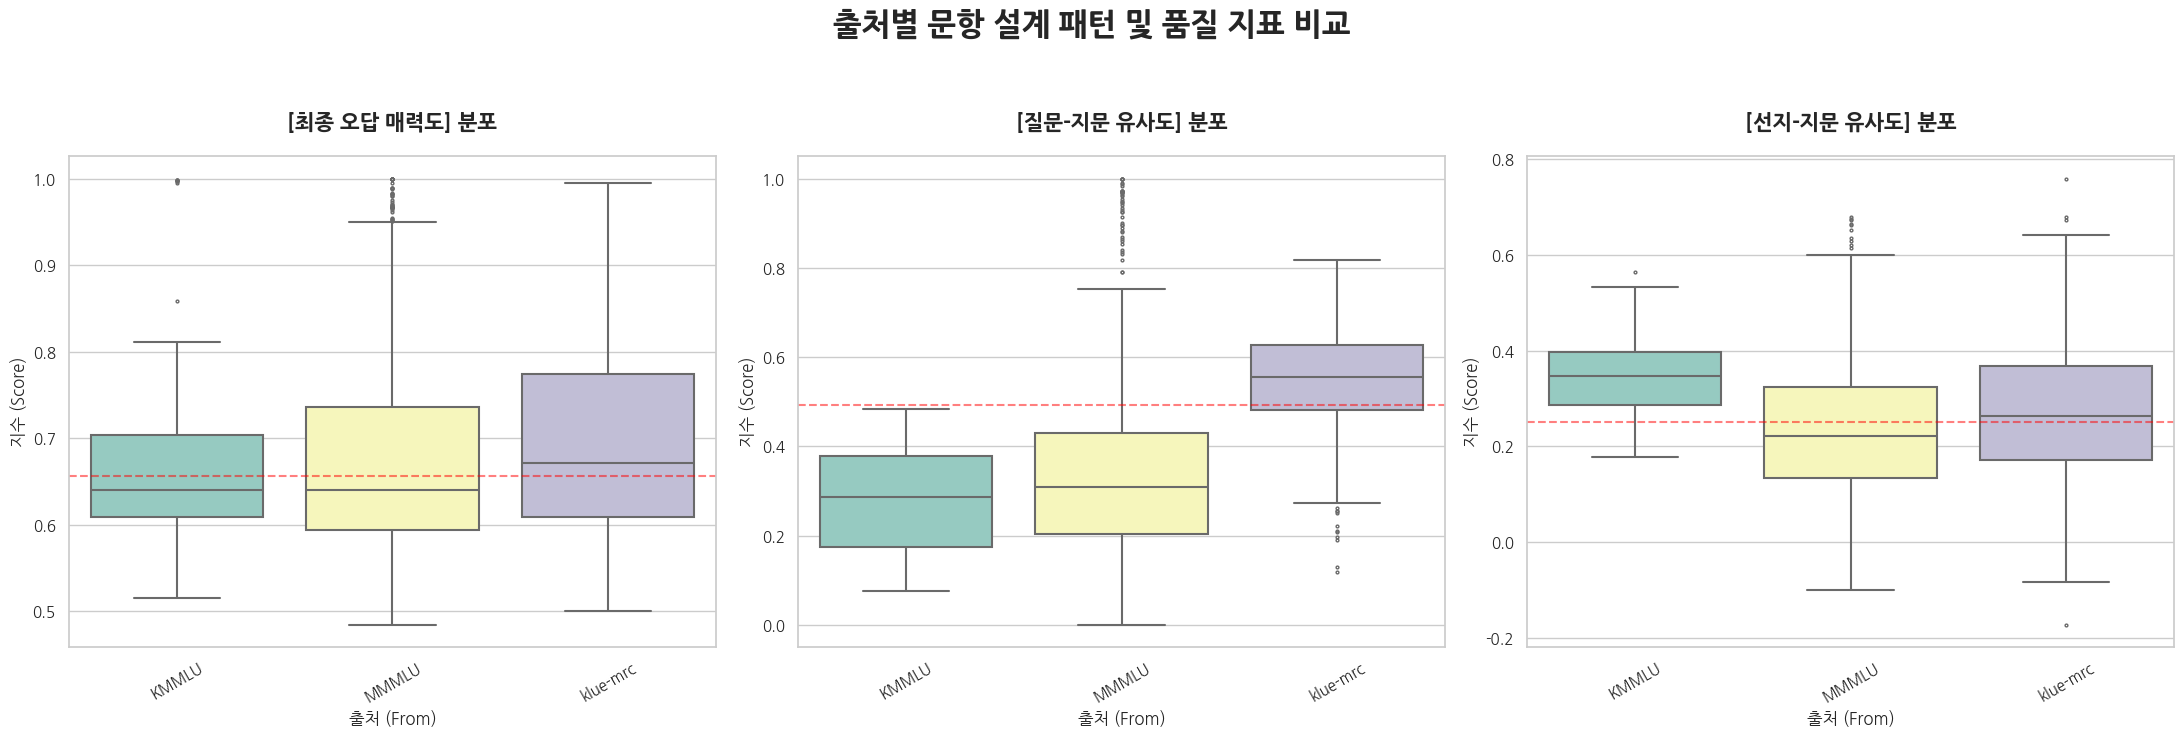

In [29]:
# 어떤 출처에서 가장 꼬아낸 문제ㅡㄹ 만드는가?
# 1. 스타일 및 한글 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

def plot_origin_quality_comparison(df):
    # 데이터가 많은 상위 주요 출처 선별
    top_origins = df['from'].value_counts().nlargest(5).index.tolist()
    df_filtered = df[df['from'].isin(top_origins)].copy()

    # 시각화할 피처 리스트 및 한글 라벨
    metrics = {
        'final_distractor_attractiveness': '최종 오답 매력도',
        'q_p_similarity': '질문-지문 유사도',
        'choice_p_similarity': '선지-지문 유사도' # '지문과 보기의 유사도' 요청 반영
    }
    
    fig, axes = plt.subplots(1, 3, figsize=(22, 7))
    plt.subplots_adjust(wspace=0.3)

    colors = ['#FAD7A0', '#AED6F1', '#A9DFBF'] # 연주황, 연파랑, 연초록

    for i, (col, label) in enumerate(metrics.items()):
        # 박스플롯 시각화
        sns.boxplot(data=df_filtered, x='from', y=col, ax=axes[i], 
                    palette='Set3', fliersize=2, linewidth=1.5)
        
        # 중앙값(Median) 수치 표시로 가독성 보완
        medians = df_filtered.groupby('from')[col].median()
        axes[i].set_title(f'[{label}] 분포', fontsize=15, fontweight='bold', pad=20)
        axes[i].set_xlabel('출처 (From)')
        axes[i].set_ylabel('지수 (Score)')
        axes[i].tick_params(axis='x', rotation=30)
        
        # 가이드라인 (전체 평균)
        axes[i].axhline(df_filtered[col].median(), color='red', linestyle='--', alpha=0.5, label='전체 중앙값')

    plt.suptitle('출처별 문항 설계 패턴 및 품질 지표 비교', fontsize=22, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# --- 실행 ---
plot_origin_quality_comparison(df)

## 과목 별 분포 확인

### 과목 별 지문, 질문, 정답 길이 분포

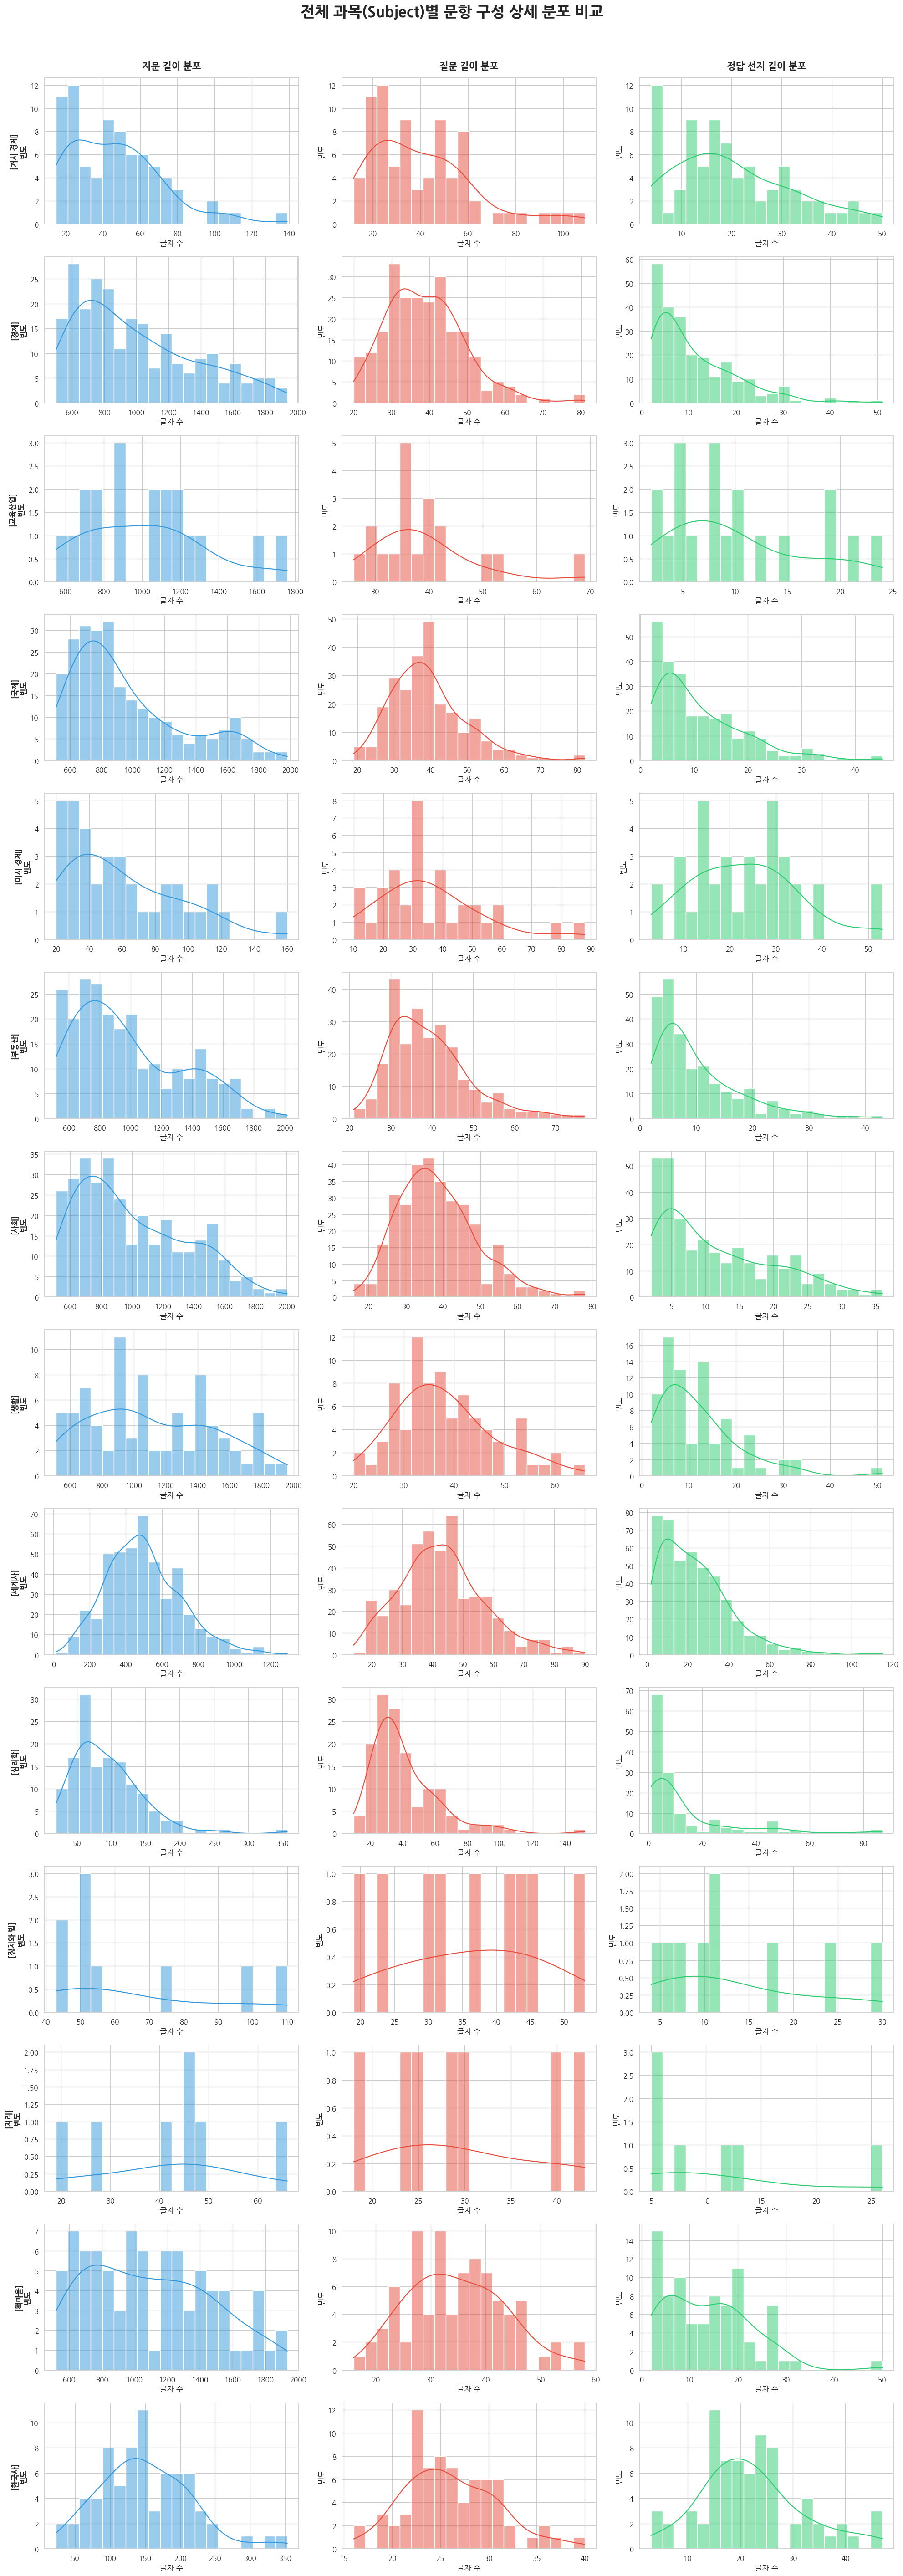

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# 1. 스타일 및 한글 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

def plot_all_subjects_histograms(df):
    df_plot = df.copy()
    
    # [데이터 전처리] 각 길이 지표 계산
    def get_answer_text_len(row):
        try:
            choices = row['choices']
            if isinstance(choices, str):
                choices = ast.literal_eval(choices)
            ans_idx = int(float(row['answer'])) - 1
            if 0 <= ans_idx < len(choices):
                return len(str(choices[ans_idx]))
            return 0
        except: return 0

    df_plot['para_len'] = df_plot['paragraph'].str.len().fillna(0)
    df_plot['q_len'] = df_plot['question'].str.len().fillna(0)
    df_plot['ans_text_len'] = df_plot.apply(get_answer_text_len, axis=1)

    # 모든 고유 과목 추출 (알파벳/가나다 순 정렬)
    all_subjects = sorted(df_plot['subject'].unique().tolist())
    n_subjects = len(all_subjects)
    
    # 3개 열(지문, 질문, 정답 선지 길이) 설정
    fig, axes = plt.subplots(n_subjects, 3, figsize=(20, 4 * n_subjects))
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    target_metrics = ['para_len', 'q_len', 'ans_text_len']
    titles = ['지문 길이 분포', '질문 길이 분포', '정답 선지 길이 분포']
    colors = ['#3498DB', '#E74C3C', '#2ECC71']

    # 과목별 루프 (행)
    for row_idx, subj in enumerate(all_subjects):
        subj_data = df_plot[df_plot['subject'] == subj]
        
        # 지표별 루프 (열)
        for col_idx, col_name in enumerate(target_metrics):
            ax = axes[row_idx, col_idx] if n_subjects > 1 else axes[col_idx]
            
            sns.histplot(subj_data[col_name], kde=True, ax=ax, color=colors[col_idx], bins=20)
            
            # 첫 번째 행에만 지표 제목 표시
            if row_idx == 0:
                ax.set_title(titles[col_idx], fontsize=15, fontweight='bold', pad=15)
            
            # 첫 번째 열에만 과목 이름 표시
            if col_idx == 0:
                ax.set_ylabel(f"[{subj}]\n빈도", fontsize=12, fontweight='bold')
            else:
                ax.set_ylabel("빈도")
                
            ax.set_xlabel("글자 수")

    plt.suptitle('전체 과목(Subject)별 문항 구성 상세 분포 비교', fontsize=24, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.show()

# --- 실행 ---
plot_all_subjects_histograms(df)

/tmp/ipykernel_273522/324699763.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='subject', y=col, ax=ax,
/tmp/ipykernel_273522/324699763.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_273522/324699763.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='subject', y=col, ax=ax,


/tmp/ipykernel_273522/324699763.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_273522/324699763.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='subject', y=col, ax=ax,
/tmp/ipykernel_273522/324699763.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/tmp/ipykernel_273522/324699763.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_filtered, x='subject', y=col,

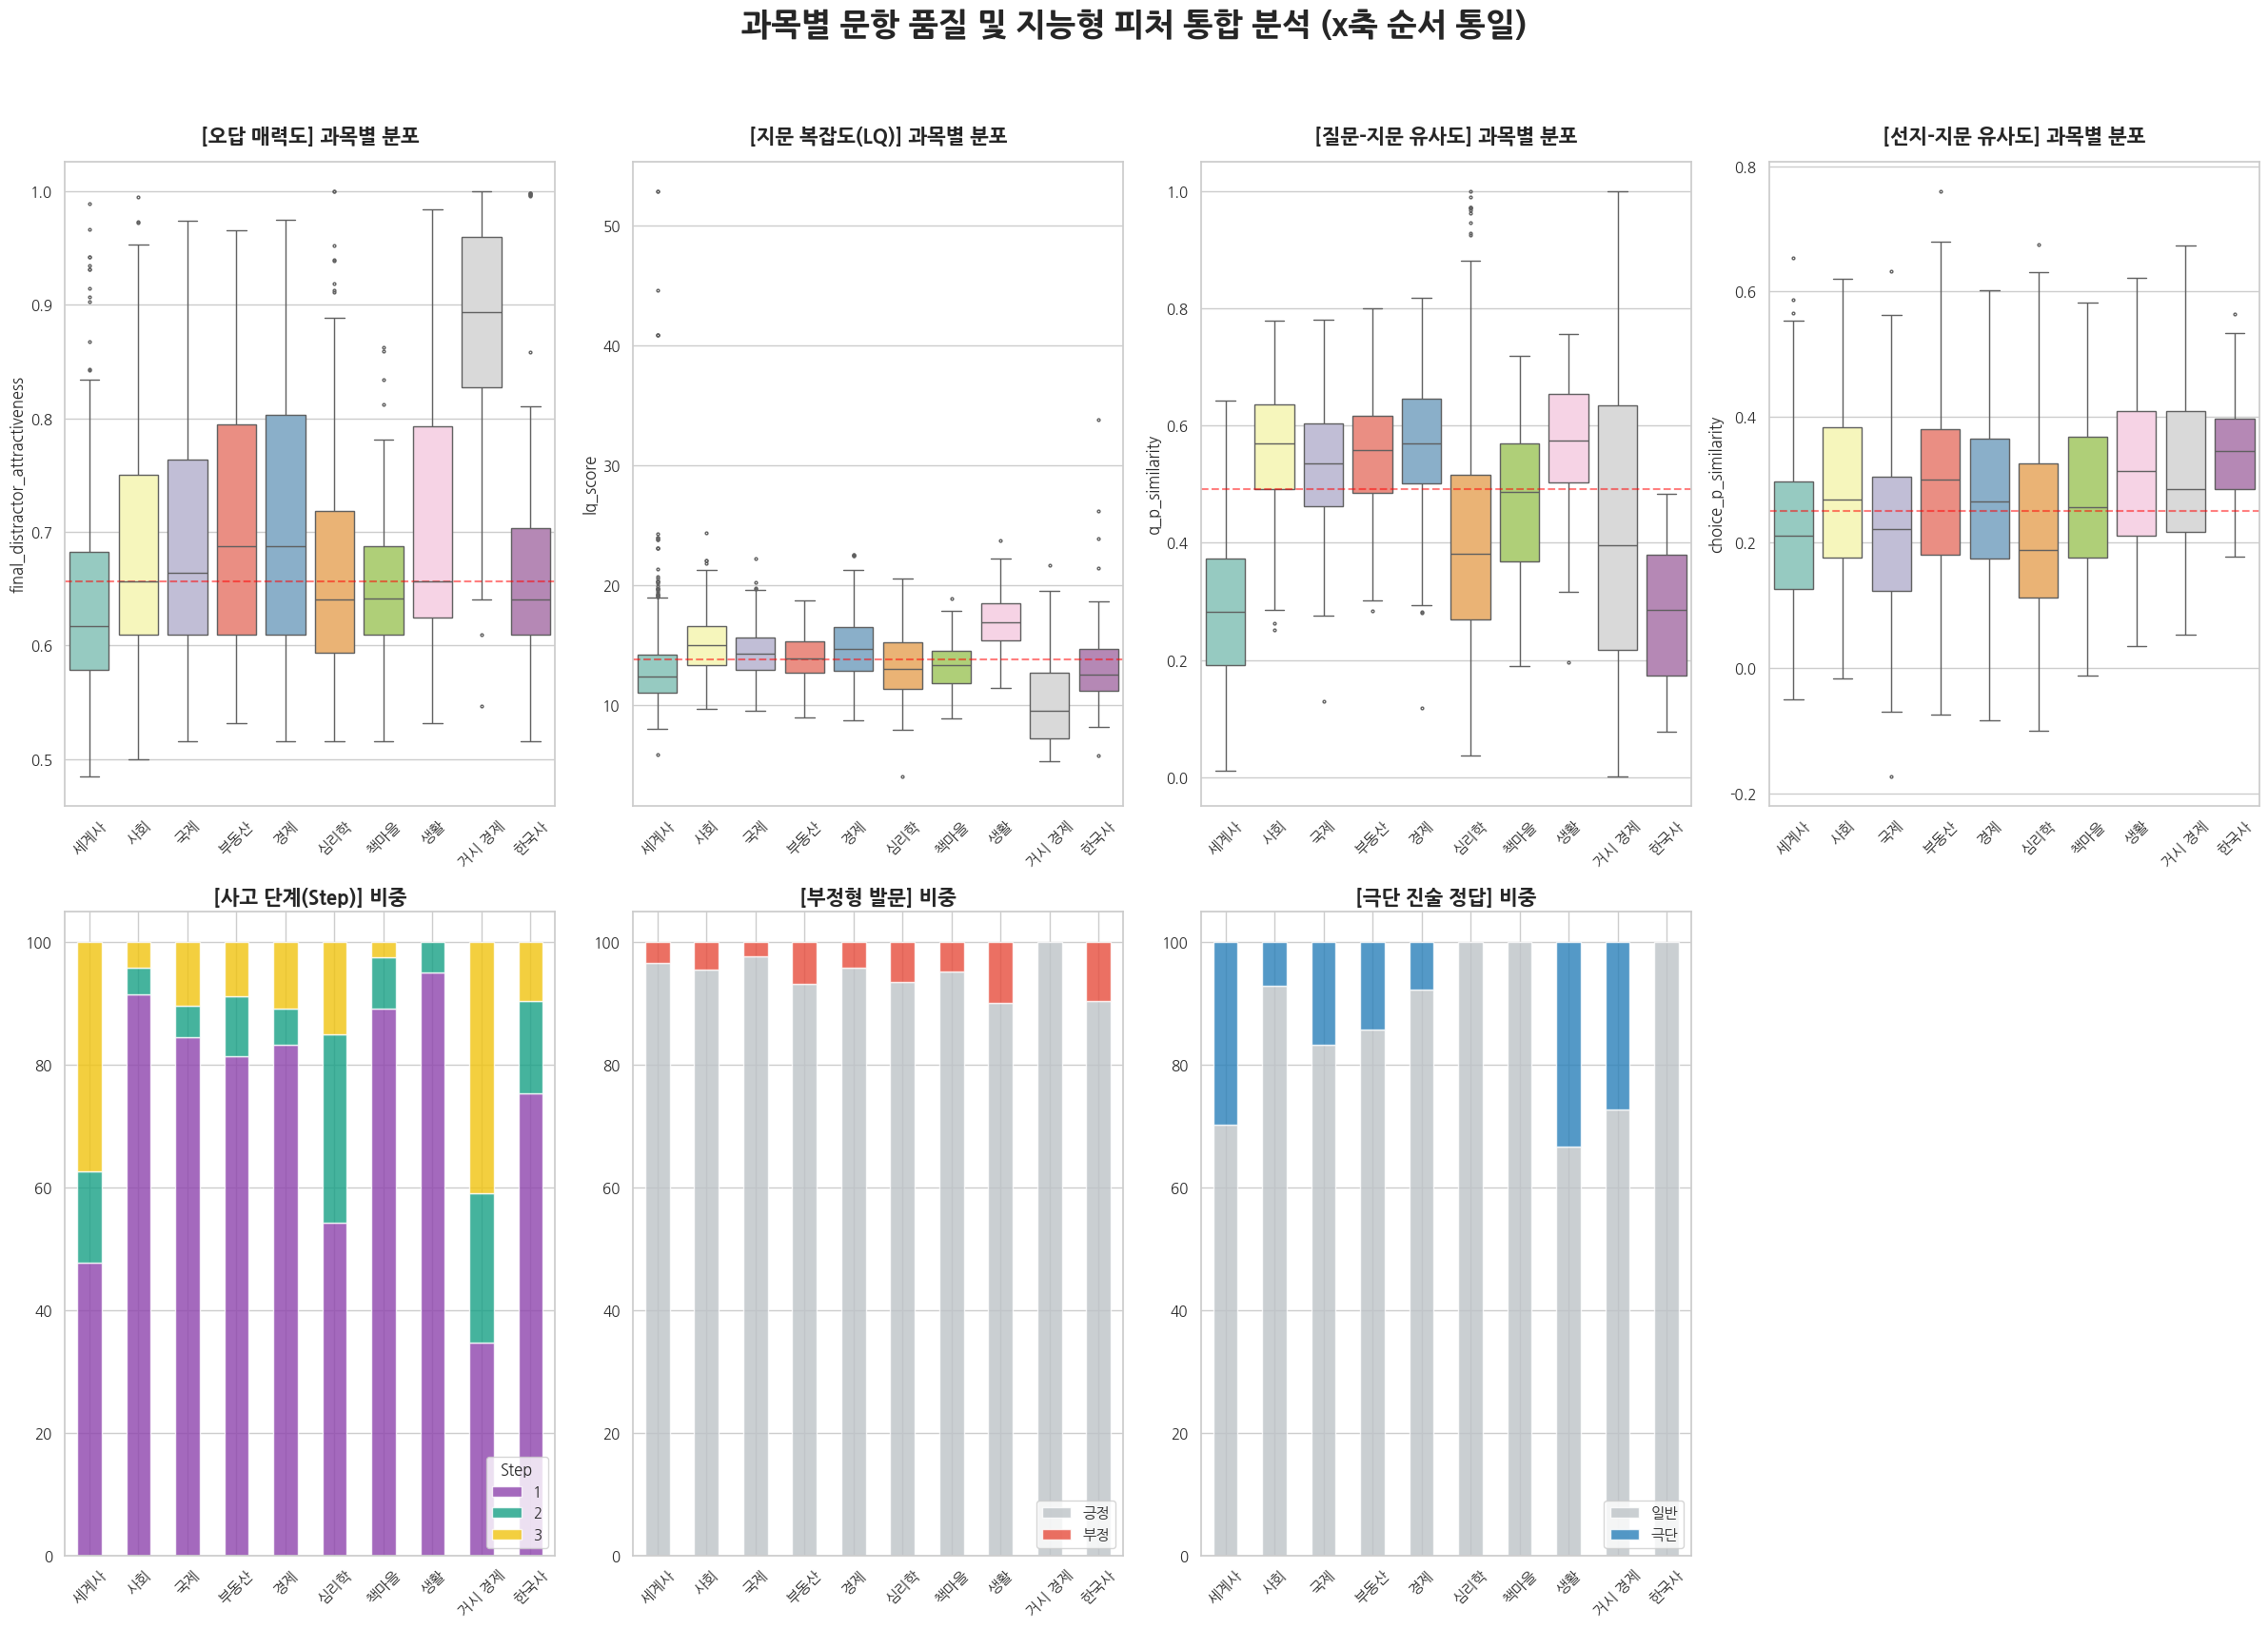

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 스타일 및 한글 설정
sns.set_theme(style="whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

def plot_subject_aligned_analysis(df):
    # 데이터가 충분한 상위 10개 과목 선별 및 순서 고정
    top_subjects = df['subject'].value_counts().nlargest(10).index.tolist()
    df_filtered = df[df['subject'].isin(top_subjects)].copy()

    # 지표 분류
    numeric_metrics = {
        'final_distractor_attractiveness': '오답 매력도',
        'lq_score': '지문 복잡도(LQ)',
        'q_p_similarity': '질문-지문 유사도',
        'choice_p_similarity': '선지-지문 유사도'
    }
    
    categorical_metrics = {
        'reasoning_step': '사고 단계(Step)',
        'is_negative_llm': '부정형 발문 비중',
        'extreme_correct_match': '극단 진술 정답 비중'
    }

    fig = plt.figure(figsize=(24, 18))
    gs = fig.add_gridspec(2, 4)

    # --- [상단] 수치형 지표 분포 (Boxplot) ---
    for i, (col, label) in enumerate(numeric_metrics.items()):
        ax = fig.add_subplot(gs[0, i])
        # order=top_subjects 옵션으로 x축 순서 강제 고정
        sns.boxplot(data=df_filtered, x='subject', y=col, ax=ax, 
                    palette='Set3', fliersize=2, order=top_subjects)
        ax.set_title(f'[{label}] 과목별 분포', fontsize=15, fontweight='bold', pad=15)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_xlabel('')
        ax.axhline(df_filtered[col].median(), color='red', linestyle='--', alpha=0.5)

    # --- [하단] 범주형 지표 비중 (Stacked Bar) ---
    # 공통: reindex(top_subjects)를 통해 x축 순서를 상단과 동일하게 맞춤

    # (1) 사고 단계 비중
    ax5 = fig.add_subplot(gs[1, 0])
    step_colors = {1.0: '#8E44AD', 2.0: '#16A085', 3.0: '#F1C40F'}
    step_pct = pd.crosstab(df_filtered['subject'], df_filtered['reasoning_step'], normalize='index') * 100
    step_pct = step_pct.reindex(top_subjects) # x축 순서 정렬
    
    step_pct.plot(kind='bar', stacked=True, ax=ax5, 
                  color=[step_colors.get(c, '#ccc') for c in step_pct.columns], alpha=0.8)
    ax5.set_title('[사고 단계(Step)] 비중', fontsize=15, fontweight='bold')
    ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45)
    ax5.set_xlabel('')
    ax5.legend(title='Step', loc='lower right')

    # (2) 부정형 발문 비중
    ax6 = fig.add_subplot(gs[1, 1])
    neg_pct = pd.crosstab(df_filtered['subject'], df_filtered['is_negative_llm'], normalize='index') * 100
    neg_pct = neg_pct.reindex(top_subjects) # x축 순서 정렬
    
    neg_pct.plot(kind='bar', stacked=True, ax=ax6, color=['#BDC3C7', '#E74C3C'], alpha=0.8)
    ax6.set_title('[부정형 발문] 비중', fontsize=15, fontweight='bold')
    ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45)
    ax6.set_xlabel('')
    ax6.legend(['긍정', '부정'], loc='lower right')

    # (3) 극단 진술 정답 비중
    ax7 = fig.add_subplot(gs[1, 2])
    ext_pct = pd.crosstab(df_filtered['subject'], df_filtered['extreme_correct_match'], normalize='index') * 100
    ext_pct = ext_pct.reindex(top_subjects) # x축 순서 정렬
    
    ext_pct.plot(kind='bar', stacked=True, ax=ax7, color=['#BDC3C7', '#2980B9'], alpha=0.8)
    ax7.set_title('[극단 진술 정답] 비중', fontsize=15, fontweight='bold')
    ax7.set_xticklabels(ax7.get_xticklabels(), rotation=45)
    ax7.set_xlabel('')
    ax7.legend(['일반', '극단'], loc='lower right')

    # 빈 공간 제거 및 레이아웃 조정
    fig.delaxes(fig.add_subplot(gs[1, 3]))
    plt.suptitle('과목별 문항 품질 및 지능형 피처 통합 분석 (x축 순서 통일)', fontsize=24, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# --- 실행 ---
plot_subject_aligned_analysis(df)

## 추가적인 EDA

### 언어적 복잡도 및 가독성 분석

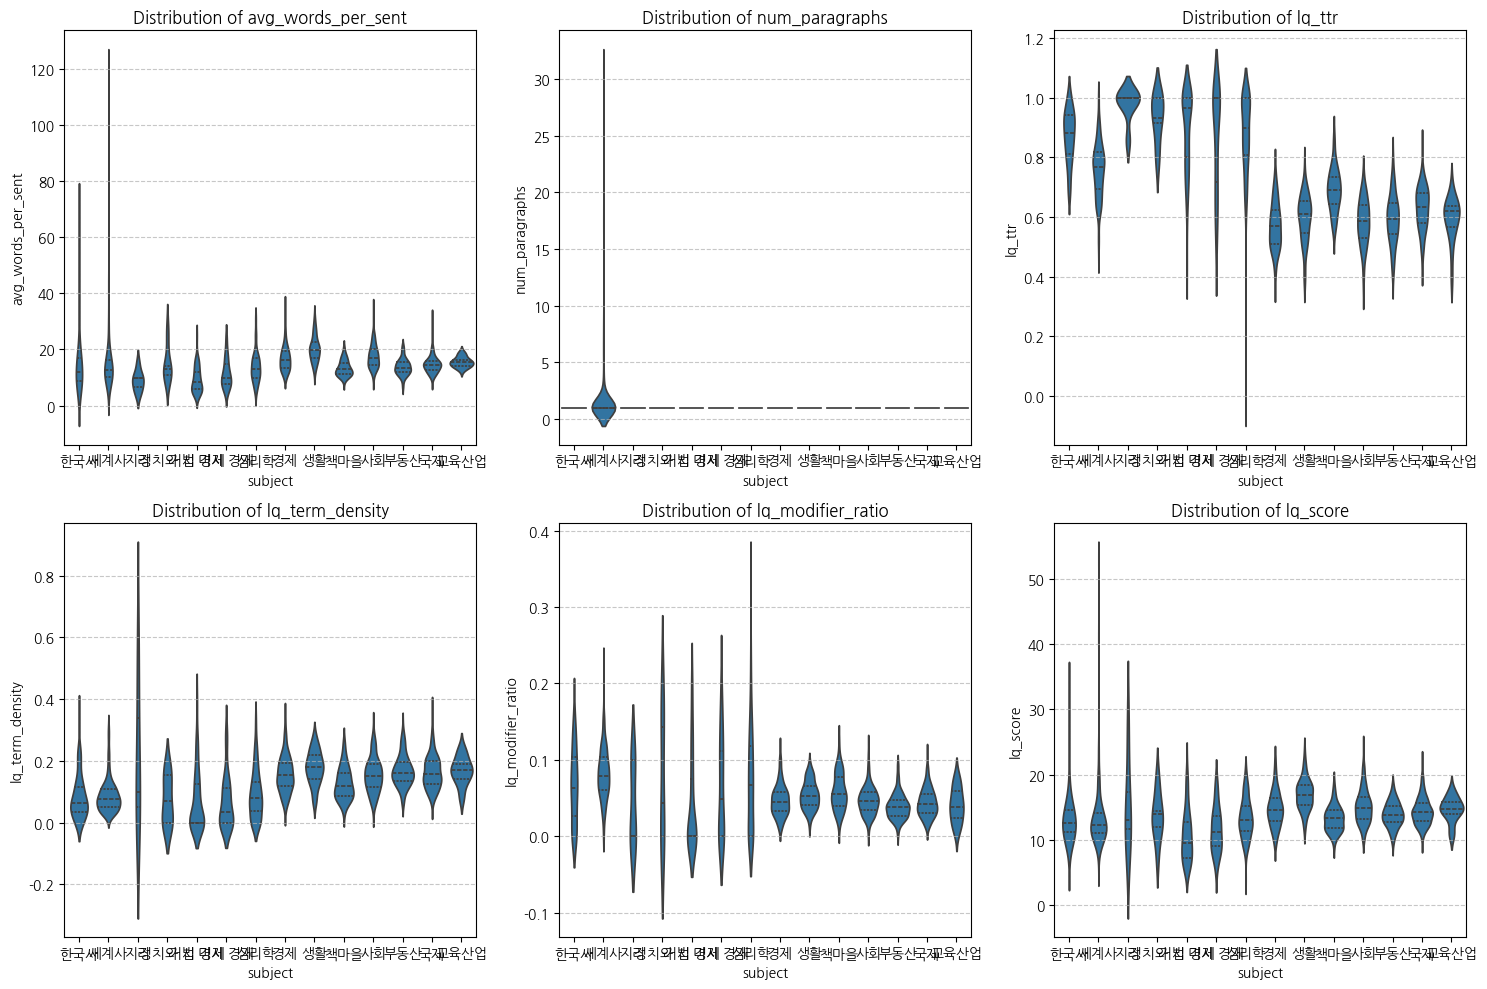

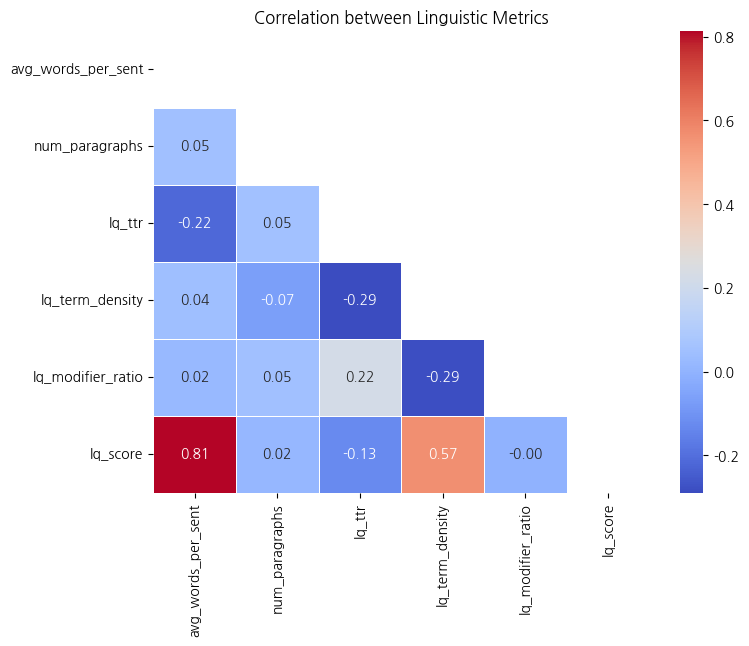

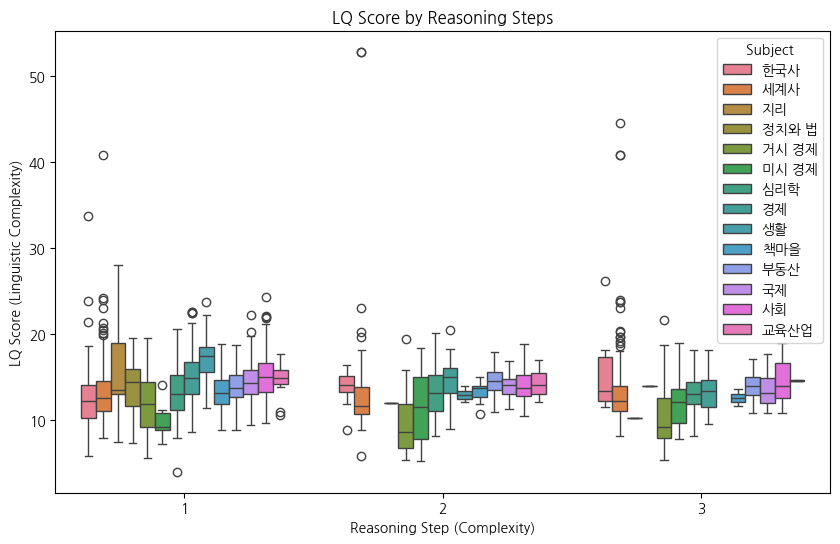

In [10]:
# 1. 가독성 및 복잡도 지표 리스트 정의
linguistic_cols = [
    'avg_words_per_sent', 'num_paragraphs', 'lq_ttr', 
    'lq_term_density', 'lq_modifier_ratio', 'lq_score'
]

def run_linguistic_eda(df):
    # print("### 언어적 복잡도 기초 통계 (과목별) ###")
    # display(df.groupby('subject')[linguistic_cols].describe().T)

    # 2. 분포 시각화 (Violin Plot)
    # 과목별로 각 지표가 어떻게 분포하는지 한눈에 확인합니다.
    plt.figure(figsize=(15, 10))
    for i, col in enumerate(linguistic_cols, 1):
        plt.subplot(2, 3, i)
        sns.violinplot(data=df, x='subject', y=col, inner="quart")
        plt.title(f'Distribution of {col}')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

    # 3. 지표 간 상관관계 분석 (Heatmap)
    # 예: 문장이 길어질수록(avg_words_per_sent) LQ Score가 올라가는가?
    plt.figure(figsize=(8, 6))
    corr = df[linguistic_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, mask=mask)
    plt.title('Correlation between Linguistic Metrics')
    plt.show()

    # 4. 복잡도(LQ Score) vs 추론 단계(Reasoning Step)
    # 복잡한 지문일수록 실제로 더 많은 추론 단계를 요구하는지 확인합니다.
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='reasoning_step', y='lq_score', hue='subject')
    plt.title('LQ Score by Reasoning Steps')
    plt.xlabel('Reasoning Step (Complexity)')
    plt.ylabel('LQ Score (Linguistic Complexity)')
    plt.legend(title='Subject')
    plt.show()

# 실행 (df는 데이터프레임 변수명)
run_linguistic_eda(df)

### 질문 - 지문 관계 및 유사도 분석

### 1. 유사도 지표 기초 통계 ###


,q_p_similarity,choice_p_similarity
count,2031.000000,2031.000000
mean,0.467263,0.261826
std,0.180565,0.138863
min,0.000641,-0.173006
25%,0.339895,0.158749
50%,0.492155,0.251544
75%,0.595394,0.361741
max,1.000000,0.759740


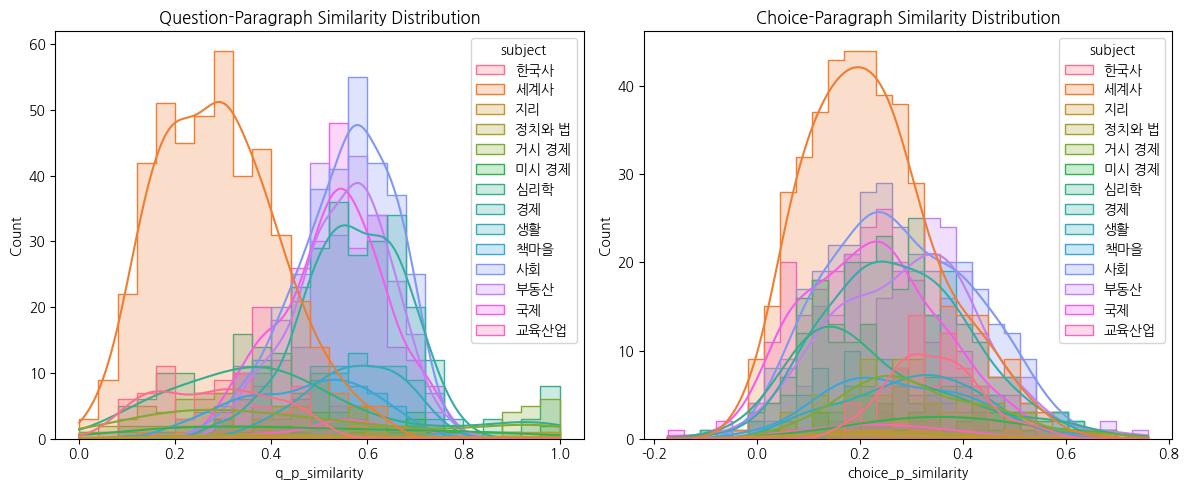

<Figure size 1000x600 with 0 Axes>

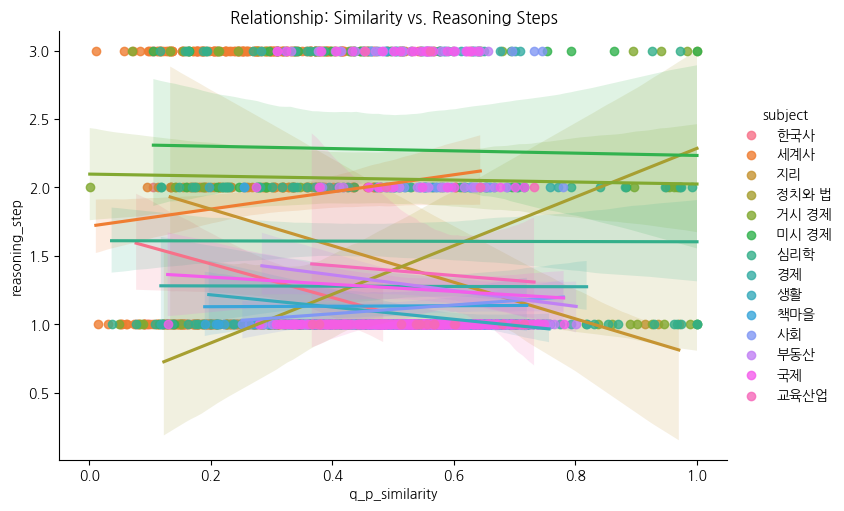

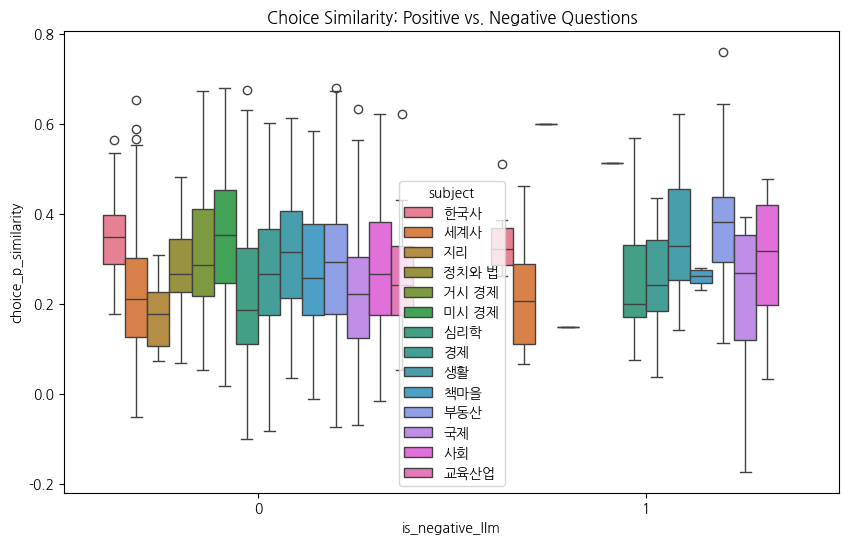

### <보기> 유무에 따른 평균 유사도 비교 ###


,q_p_similarity,choice_p_similarity
has_question_plus,,
False,0.467263,0.261826


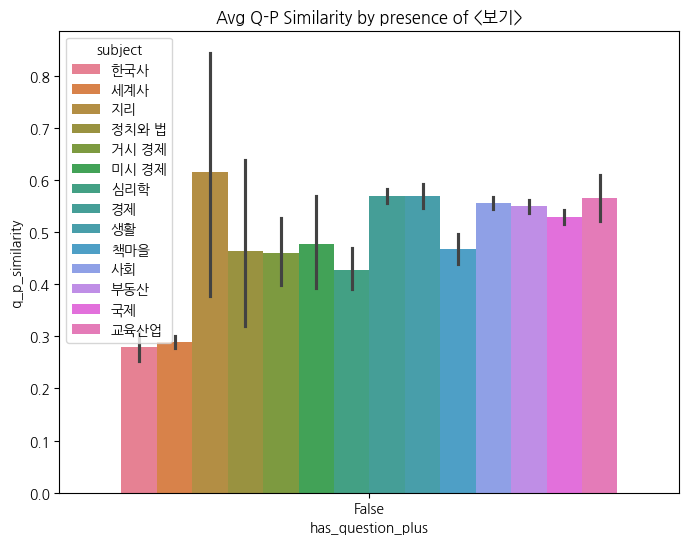

In [6]:
def run_similarity_relationship_eda(df):
    # 0. 전처리: question_plus 존재 여부 컬럼 생성
    df['has_question_plus'] = df['question_plus'].apply(lambda x: False if pd.isna(x) or x == "" or x == "None" else True)

    print("### 1. 유사도 지표 기초 통계 ###")
    display(df[['q_p_similarity', 'choice_p_similarity']].describe())

    # 1. 유사도 분포 시각화 (질문 vs 선택지)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='q_p_similarity', hue='subject', kde=True, element="step")
    plt.title('Question-Paragraph Similarity Distribution')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x='choice_p_similarity', hue='subject', kde=True, element="step")
    plt.title('Choice-Paragraph Similarity Distribution')
    plt.tight_layout()
    plt.show()

    # 2. 유사도와 추론 단계(Reasoning Step)의 상관관계
    # 일반적으로 유사도가 높을수록 추론 단계가 낮아야 함 (단순 일치 문제)
    plt.figure(figsize=(10, 6))
    sns.lmplot(data=df, x='q_p_similarity', y='reasoning_step', hue='subject', aspect=1.5)
    plt.title('Relationship: Similarity vs. Reasoning Steps')
    plt.show()

    # 3. 부정형 질문(is_negative_llm)에 따른 유사도 차이
    # "~가 아닌 것은?" 문제는 지문과 선택지의 유사도 패턴이 다를 수 있음
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='is_negative_llm', y='choice_p_similarity', hue='subject')
    plt.title('Choice Similarity: Positive vs. Negative Questions')
    plt.show()

    # 4. <보기>(question_plus) 유무에 따른 유사도 분석
    # 보기가 있는 문제는 지문과의 직접 유사도가 낮아질 수 있음 (보기를 거쳐야 하므로)
    print("### <보기> 유무에 따른 평균 유사도 비교 ###")
    display(df.groupby('has_question_plus')[['q_p_similarity', 'choice_p_similarity']].mean())
    
    plt.figure(figsize=(8, 6))
    sns.barplot(data=df, x='has_question_plus', y='q_p_similarity', hue='subject')
    plt.title('Avg Q-P Similarity by presence of <보기>')
    plt.show()

# 실행
run_similarity_relationship_eda(df)

### 오답 매력도 및 난이도 사분면 분석

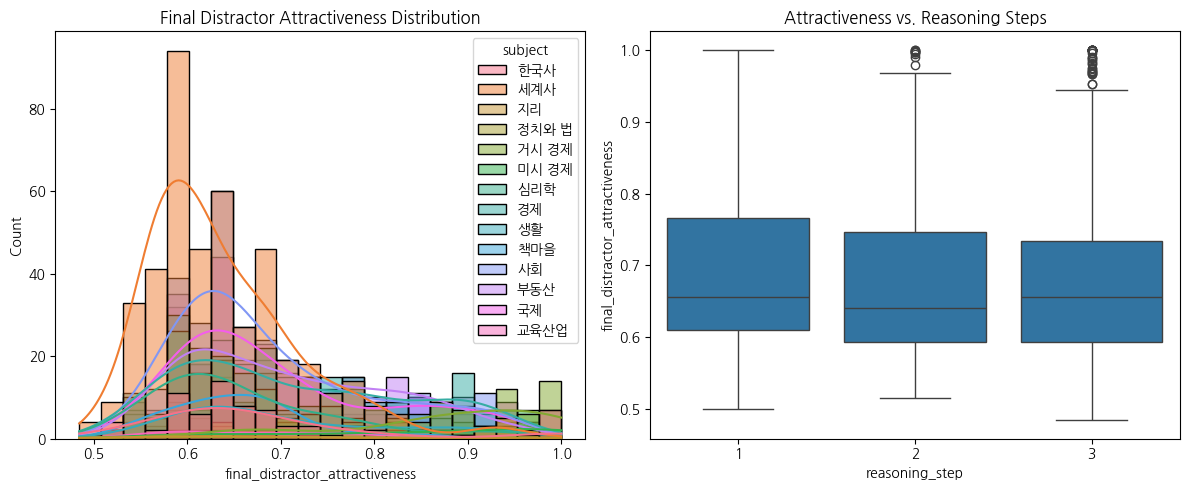

### 사분면별 데이터 분포 ###


subject,거시 경제,경제,교육산업,국제,미시 경제,부동산,사회,생활,세계사,심리학,정치와 법,지리,책마을,한국사
quadrant_label,,,,,,,,,,,,,,
Q1 (우상단),0,11,0,5,1,17,13,8,15,9,1,1,4,8
Q2 (좌상단),0,0,0,0,0,0,0,0,5,0,0,0,0,0
Q3 (좌하단),0,0,0,0,0,0,0,0,1,0,0,0,0,0
Q4 (우하단),78,228,19,247,35,231,304,73,428,131,8,6,79,65


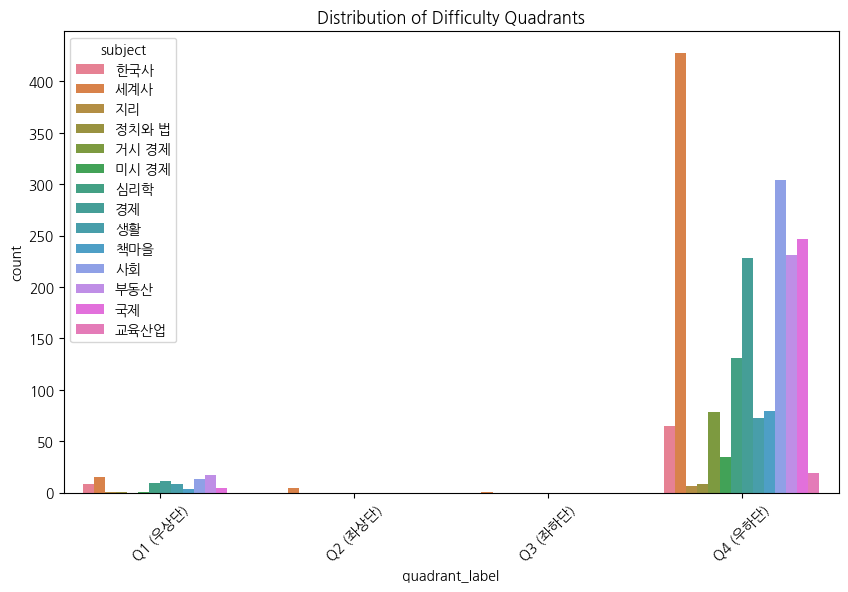

### Killer 문제(상위 25% 매력도 & 3단계 이상 추론) 개수: 72 ###
과목별 킬러 문제 비율:
subject
거시 경제    0.388889
세계사      0.194444
미시 경제    0.180556
심리학      0.111111
경제       0.041667
한국사      0.027778
국제       0.027778
부동산      0.013889
사회       0.013889
Name: proportion, dtype: float64


In [7]:
def run_distractor_difficulty_eda(df):
    # 1. 오답 매력도(Distractor Attractiveness) 분포 분석
    # final_distractor_attractiveness는 최종적으로 보정된 오답의 유혹 강도입니다.
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x='final_distractor_attractiveness', hue='subject', kde=True)
    plt.title('Final Distractor Attractiveness Distribution')

    # 2. 추론 단계와 오답 매력도의 관계
    # 추론 단계가 많을수록 오답 매력도도 높아지는지 확인 (함정의 깊이 확인)
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df, x='reasoning_step', y='final_distractor_attractiveness')
    plt.title('Attractiveness vs. Reasoning Steps')
    plt.tight_layout()
    plt.show()

    # 3. 사분면 라벨(Quadrant Label) 분석
    # 사분면은 보통 (지문 복잡도 x 문제 난이도)로 정의됩니다.
    print("### 사분면별 데이터 분포 ###")
    quadrant_counts = df.groupby(['quadrant_label', 'subject']).size().unstack(fill_value=0)
    display(quadrant_counts)

    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x='quadrant_label', hue='subject', order=sorted(df['quadrant_label'].unique()))
    plt.title('Distribution of Difficulty Quadrants')
    plt.xticks(rotation=45)
    plt.show()

    # 4. 고난도 'Killer' 문제 식별
    # 오답 매력도가 높고 추론 단계가 많은 데이터들을 별도 슬라이싱
    killer_threshold = df['final_distractor_attractiveness'].quantile(0.75)
    killer_problems = df[(df['final_distractor_attractiveness'] >= killer_threshold) & (df['reasoning_step'] >= 3)]
    
    print(f"### Killer 문제(상위 25% 매력도 & 3단계 이상 추론) 개수: {len(killer_problems)} ###")
    print(f"과목별 킬러 문제 비율:\n{killer_problems['subject'].value_counts(normalize=True)}")

# 실행
run_distractor_difficulty_eda(df)

## 데이터 증강 및 few-shot 선정 위한 임베딩 클러스터 분석

Step 1: Embedding...


/data/ephemeral/home/moon/csat/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Batches:   0%|          | 0/64 [00:00<?, ?it/s]

Step 2: Fitting KMeans...
Step 3: Dimensionality Reduction...


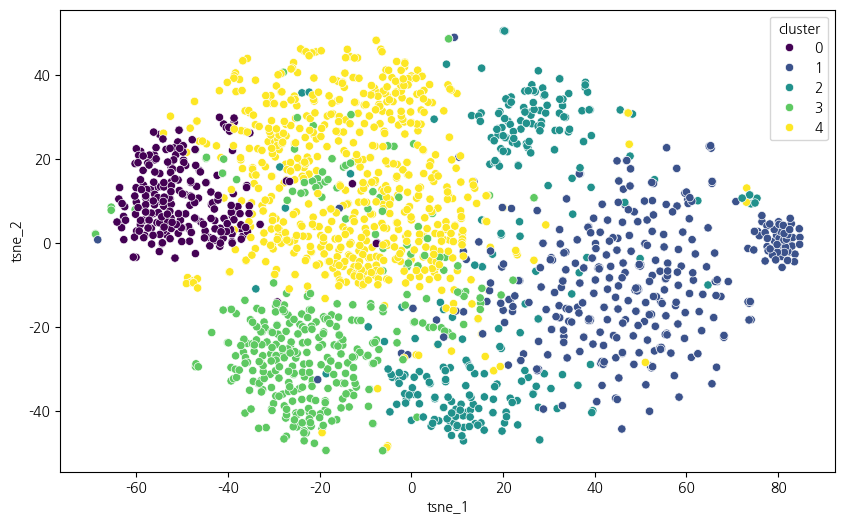

In [17]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def run_embedding_clustering_v3(df, n_clusters=5):
    # 텍스트 결합 및 임베딩 생성
    df['combined_text'] = df['paragraph'].astype(str) + " [SEP] " + df['question'].astype(str)
    
    print("Step 1: Embedding...")
    # 접근성 좋은 모델 사용
    model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
    embeddings = model.encode(df['combined_text'].tolist(), show_progress_bar=True)
    
    print("Step 2: Fitting KMeans...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    # 핵심: fit을 호출해야 labels_가 생깁니다.
    df['cluster'] = kmeans.fit_predict(embeddings) 
    
    print("Step 3: Dimensionality Reduction...")
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(embeddings)
    df['tsne_1'], df['tsne_2'] = tsne_results[:, 0], tsne_results[:, 1]
    
    # 시각화 및 요약 출력 (생략 가능하나 확인용으로 추천)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='cluster', data=df, palette='viridis')
    plt.show()
    
    return df, df.groupby('cluster').mean(numeric_only=True)

# 실행
df, cluster_summary = run_embedding_clustering_v3(df)

### 효과적인 truncation 찾기

### 전략 2: Shortcut Learning 분석 시작 ###


/tmp/ipykernel_274652/3571774123.py:26: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df['correct_len'], label='Correct Choice', fill=True)
/tmp/ipykernel_274652/3571774123.py:27: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df['wrong_avg_len'], label='Wrong Choices', fill=True)
/tmp/ipykernel_274652/3571774123.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


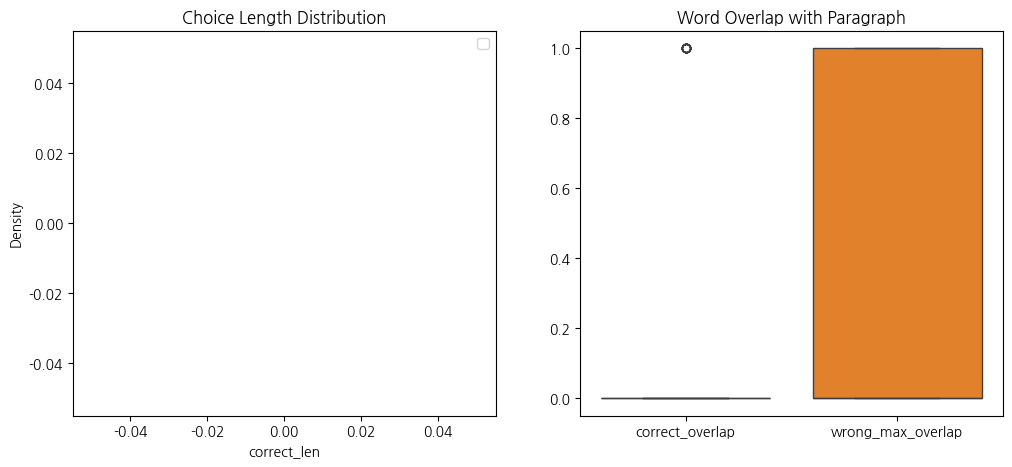

평균 길이 차이: 0.00 (0보다 훨씬 크면 모델이 길이만 보고 찍을 위험 높음)
정답이 단어 겹침이 가장 많을 확률: 0.00 (0.5 이상이면 단순 매칭 문제 위주)


In [19]:
def analyze_shortcuts(df):
    print("### 전략 2: Shortcut Learning 분석 시작 ###")
    
    # 1. 길이 편향(Length Bias) 분석
    # 각 선택지의 길이를 계산
    df['choice_lens'] = df['choices'].apply(lambda x: [len(str(c)) for c in x])
    df['ans_idx'] = df['answer'].astype(int) - 1
    
    # 정답 선택지의 길이 vs 나머지 오답들의 평균 길이
    df['correct_len'] = df.apply(lambda row: row['choice_lens'][row['ans_idx']], axis=1)
    df['wrong_avg_len'] = df.apply(lambda row: np.mean([l for i, l in enumerate(row['choice_lens']) if i != row['ans_idx']]), axis=1)
    
    # 2. 단어 겹침(Word Overlap) 분석
    # 지문에 나온 단어가 선택지에 얼마나 많이 포함되어 있는가?
    def get_overlap(paragraph, choice):
        p_set = set(str(paragraph).split())
        c_set = set(str(choice).split())
        return len(p_set.intersection(c_set))

    df['correct_overlap'] = df.apply(lambda row: get_overlap(row['paragraph'], row['choices'][row['ans_idx']]), axis=1)
    df['wrong_max_overlap'] = df.apply(lambda row: max([get_overlap(row['paragraph'], c) for i, c in enumerate(row['choices']) if i != row['ans_idx']]), axis=1)

    # 시각화: 길이 편향
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.kdeplot(df['correct_len'], label='Correct Choice', fill=True)
    sns.kdeplot(df['wrong_avg_len'], label='Wrong Choices', fill=True)
    plt.title('Choice Length Distribution')
    plt.legend()

    # 시각화: 단어 겹침
    plt.subplot(1, 2, 2)
    sns.boxplot(data=df[['correct_overlap', 'wrong_max_overlap']])
    plt.title('Word Overlap with Paragraph')
    plt.show()

    # 결과 해석 지표
    len_diff = df['correct_len'].mean() - df['wrong_avg_len'].mean()
    print(f"평균 길이 차이: {len_diff:.2f} (0보다 훨씬 크면 모델이 길이만 보고 찍을 위험 높음)")
    
    overlap_win_rate = (df['correct_overlap'] > df['wrong_max_overlap']).mean()
    print(f"정답이 단어 겹침이 가장 많을 확률: {overlap_win_rate:.2f} (0.5 이상이면 단순 매칭 문제 위주)")

# 실행
analyze_shortcuts(df)

### 효율적 컨텍스트 관리를 위한 정보 밀도 분석

### 전략 3: 정보 밀도 및 정답 근거 위치 분석 시작 ###


/data/ephemeral/home/moon/csat/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/tmp/ipykernel_274652/3833002969.py:49: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=pos_df, x='relative_pos', hue='subject', fill=True, common_norm=False)


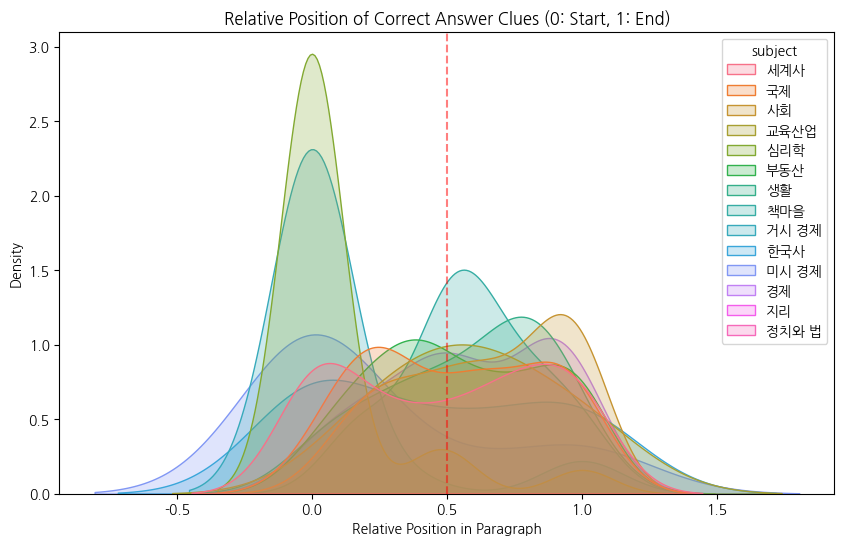


### 과목별 정답 근거 평균 위치 (0=시작, 1=끝) ###
             mean       50%       std
subject                              
거시 경제    0.097222  0.000000  0.286224
경제       0.584268  0.569444  0.315573
교육산업     0.597222  0.583333  0.325131
국제       0.532362  0.563492  0.321452
미시 경제    0.250000  0.000000  0.424918
부동산      0.547654  0.500000  0.315161
사회       0.639142  0.658333  0.303183
생활       0.574557  0.642857  0.301275
세계사      0.489819  0.500000  0.375983
심리학      0.090698  0.000000  0.246706
정치와 법    0.000000  0.000000  0.000000
지리       0.000000  0.000000  0.000000
책마을      0.590813  0.562609  0.249841
한국사      0.449074  0.416667  0.426970


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import re

def analyze_information_density(df):
    print("### 전략 3: 정보 밀도 및 정답 근거 위치 분석 시작 ###")
    
    # 1. 모델 로드 (가장 안정적인 모델 사용)
    try:
        model = SentenceTransformer('snunlp/KR-SBERT-V40K-klueNLI-augSTS')
    except:
        model = SentenceTransformer('sentence-transformers/distiluse-base-multilingual-cased-v1')

    clue_positions = []
    
    # 데이터가 많을 경우 상위 500개 정도만 샘플링해서 경향성을 파악해도 충분합니다.
    sample_df = df.sample(min(500, len(df)), random_state=42).copy()

    for idx, row in sample_df.iterrows():
        # 지문을 문장 단위로 분리 (간단하게 마침표 기준)
        sentences = [s.strip() for s in re.split(r'(?<=[.!?])\s+', row['paragraph']) if len(s.strip()) > 5]
        if not sentences: continue
        
        # 정답 선택지 임베딩
        correct_choice = str(row['choices'][int(row['answer'])-1])
        ans_emb = model.encode([correct_choice])
        sent_embs = model.encode(sentences)
        
        # 각 문장과 정답의 유사도 계산
        sims = cosine_similarity(ans_emb, sent_embs)[0]
        
        # 가장 유사도가 높은 문장의 위치 (0~1 사이로 정규화: 0은 지문 시작, 1은 끝)
        best_sent_idx = np.argmax(sims)
        relative_pos = best_sent_idx / (len(sentences) - 1) if len(sentences) > 1 else 0
        clue_positions.append({
            'subject': row['subject'],
            'relative_pos': relative_pos,
            'max_sim': np.max(sims)
        })

    pos_df = pd.DataFrame(clue_positions)

    # 2. 시각화: 정답 근거 위치 분포
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=pos_df, x='relative_pos', hue='subject', fill=True, common_norm=False)
    plt.title('Relative Position of Correct Answer Clues (0: Start, 1: End)')
    plt.xlabel('Relative Position in Paragraph')
    plt.ylabel('Density')
    plt.axvline(0.5, color='red', linestyle='--', alpha=0.5)
    plt.show()

    # 3. 과목별 평균 근거 위치 출력
    print("\n### 과목별 정답 근거 평균 위치 (0=시작, 1=끝) ###")
    print(pos_df.groupby('subject')['relative_pos'].describe()[['mean', '50%', 'std']])

    return pos_df

# 실행
pos_analysis_df = analyze_information_density(df)